# FORESEE - Heavy Neutral Leptons (HNLs)

### Load Libraries 

In [1]:
import numpy as np
import sys
import os
import matplotlib.colors as mcolors
src_path = "/Users/alechewitt/Desktop/Git_felix_new/FORESEE"
sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model

from HeavyNeutralLepton import * 

from matplotlib import pyplot as plt
import pandas as pd
import os
import glob

from matplotlib import pyplot as plt
import pandas as pd
from os.path import exists

from scipy.integrate import quad

## 1. Initialization 


All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [2]:
foresee = Foresee()

HNL's are produced mainly via D and $B$ meson decay. To start, let us have a look at the $\text{D}^+$ spectrum in terms of the angle with respect to the beam axis $\theta$ and the momentum $p$. This can be done using the function `get_spectrumplot` which requires the MC particle ID (or simply pid), the MC generator and the energy. The units on the coloraxis are pb/bin. 

FORESEE provides the 2D spectrum as tables for a variety of particles ($\pi$, $\eta$, D, B, ...), generators (SIBYLL, EPOSLHC, QGSJET, PYTHIA) and collision energies (14, 27 and 100 TeV). The datafiles are stored in the directory `files/hadrons`. Let us show the $\text{D}^+$ spectrum obained by Pythia8. 

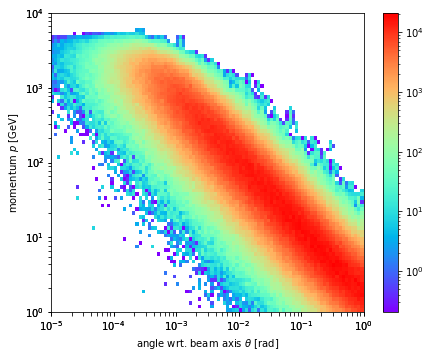

In [3]:
plot=foresee.get_spectrumplot(pid="15", generator="pythia8", energy="14",  prange=[[-5, 0, 100],[ 0, 4, 80]])
plot.show()

## 2. Specifying the Model: Heavy Neutral Leptons

In this notebook we consider Heavy Neutral Leptons (HNLs) $N$. These for example naturally arise in models with an addition right handed neutrinos. Their phenomenology is described by a the folling Lagrangian 

\begin{equation}
 \mathcal{L} = \bar N (i \gamma^\mu \partial_mu - \color{red}{m_N}) N - (g/\sqrt{2}) \color{red}{U_{\alpha}} W_\mu \bar \ell_\alpha \gamma^\mu N - (g/\sqrt{2} c_W) \color{red}{U_{\alpha}} Z_\mu \bar \nu_\alpha \gamma^\mu N 
\end{equation}

where $\color{red}{m_N}$ is the HNL mass, and $\color{red}{U_{\alpha}}$ are the mixings of the HNL with the SM neutrinos of flavour $\alpha=e,\mu, \tau$. For practical purposes, we will define $\color{red}{U_{\alpha}} = \color{red}{g} \times V_\alpha$ where $V_\alpha$ is fixed. In this case the HNL mass $\color{red}{m_N}$ and the coupling $\color{red}{g}$ are the free parameters of the model. 

Since the HNL model is rather complicted, we will use dedicated the `HeavyNeutralLepton` class, which will provide all properties of the model, eg their the *production rate*, the *lifetime* and their *decay branching fractions*. It will be initialized with the values of $V_\alpha$.

In [4]:
hnl = HeavyNeutralLepton(ve=1, vmu=0, vtau=0)
nsteps=100


All properties are specified in the `Model` class. We initialize it with the name of the model as argument. 

In [5]:
energy = "14"
modelname="HNL"
model = Model(modelname, path="./")
allchannels = []
production_channels=[]

### a) HNL Production
As most LLPs, HNLs are produced in the decay of primary hadrons. Here we need to specify the total branching fraction into the LLP as function of the `coupling` and the `mass`. 

**Production via 2-body decays** HNLs can be produced in 2-body decays of the type $H^+ \to \ell N$. The corresponding branching fractions are given by  

\begin{equation}
    \text{BR}(H^+ \rightarrow \ell_{\alpha}^{+} N ) =   |U_{\alpha}|^2 \frac{G_F^2 M_H M_N^2 \tau_H f_H |V_H|^2 }{8 \pi}  \cdot \left[ 1- \frac{M_N^2}{M_H^2} + 2 \frac{M_{\ell}^2}{M_H^2}+ \frac{M_{\ell}^2}{M_N^2} \left( 1- \frac{M_{\ell}^2}{M_H^2} \right) \right] \times \left[\left(1+ \frac{M_N^2}{M_H^2}- \frac{M_{\ell}^2}{M_H^2}\right)^2 - 4 \frac{M_N^2}{M_H^2}\right]^{1/2}
\end{equation}

In particular we consider the decays:
- $D^\pm, D_s^\pm, B^\pm, B_c^\pm \to \ell^\pm N$

In [6]:
#colors for plots
import random
colors=list(mcolors.CSS4_COLORS)
length=len(colors)


In [7]:
channels = [
    [r'D^+ \to l^+ + N'    , '411', '-'],
    [r'D^- \to l^- + N'    ,'-411', '' ],
    [r'D_s^+ \to l^+ + N'  , '431', '-'],
    [r'D_s^- \to l^- + N'  ,'-431', '' ],
    [r'B^+ \to + l^+ + N'  , '521', '-'],
    [r'B^- \to + l^- + N'  ,'-521', '' ],
    [r'B_c^+ \to + l^+ + N', '541', '-'],
    [r'B_c^- \to + l^- + N','-541', '' ],
    [r'pi^+ \to + l^+ + N','211', '-' ],
    [r'pi^- \to + l^- + N','-211', '' ],
    [r'K^+ \to + l^+ + N','321', '-' ],
    [r'K^- \to + l^- + N','-321', '' ]
]


    
for label, pid_had, sign_lep in channels:
    for pid_lep in ["11","13","15"]:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        #print (r"added decay: "+label+" for l="+hnl.lepton[pid_lep])    
        label1 = "2body_" + pid_had + "_" + sign_lep+pid_lep
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        model.add_production_2bodydecay(
            label = label1,
            pid0 = pid_had,
            pid1 = pid_lep,
            br = hnl.get_2body_br(pid_had, sign_lep+pid_lep),
            generator = "Pythia8",
            energy = energy,
            nsample = nsteps,
        )
        allchannels.append(label1)

["2body_411_-11", "slateblue", r"$D^+ \to l^+ + N$"],
["2body_-411_11", "purple", r"$D^- \to l^- + N$"],
["2body_431_-11", "forestgreen", r"$D_s^+ \to l^+ + N$"],
["2body_-431_11", "mediumblue", r"$D_s^- \to l^- + N$"],
["2body_521_-11", "lightblue", r"$B^+ \to + l^+ + N$"],
["2body_-521_11", "rosybrown", r"$B^- \to + l^- + N$"],
["2body_541_-11", "fuchsia", r"$B_c^+ \to + l^+ + N$"],
["2body_-541_11", "darkorchid", r"$B_c^- \to + l^- + N$"],
["2body_211_-11", "ivory", r"$pi^+ \to + l^+ + N$"],
["2body_-211_11", "aqua", r"$pi^- \to + l^- + N$"],
["2body_321_-11", "darkolivegreen", r"$K^+ \to + l^+ + N$"],
["2body_-321_11", "sienna", r"$K^- \to + l^- + N$"],


**Production via 2-body $\tau$ decays** HNLs can be produced in 2-body decays of the type $\tau \to H N$, the corresponding branching fraction is given by

\begin{aligned}
    \mathrm{Br}(\tau \rightarrow \mathrm{HN}) &=\tau_\tau \cdot \frac{\left|U_\tau\right|^2}{16 \pi} G_F^2\left|V_H\right|^2 f_H^2 M_\tau^3 \cdot\left(\left(1-\frac{M_N^2}{M_\tau^2}\right)^2-\frac{M_H^2}{M_\tau^2}\left(1+\frac{M_N^2}{M_\tau^2}\right)\right) \\
    & \times \sqrt{\left(1-\frac{\left(M_H-M_N\right)^2}{M_\tau^2}\right)\left(1-\frac{\left(M_H+M_N\right)^2}{M_\tau^2}\right)}
\end{aligned}

or of the form $\tau \to \rho N$, in this case the branching fraction is given by

\begin{aligned}
    \mathrm{Br}(\tau \rightarrow \rho \mathrm{N}) &=\tau_\tau \cdot \frac{\left|U_\tau\right|^2}{8 \pi} \frac{g_\rho^2}{M_\rho^2} G_F^2\left|V_{u d}\right|^2 M_\tau^3 \cdot\left(\left(1-\frac{M_N^2}{M_\tau^2}\right)^2+\frac{M_\rho^2}{M_\tau^2}\left(1+\frac{M_N^2-2 M_\rho^2}{M_\tau^2}\right)\right) \\
    & \times \sqrt{\left(1-\frac{\left(M_\rho-M_N\right)^2}{M_\tau^2}\right)\left(1-\frac{\left(M_\rho+M_N\right)^2}{M_\tau^2}\right)}
\end{aligned}

In particular we consider the decays:
- $\tau^{\pm} \to \pi^{\pm},K^{\pm}, \rho^{\pm} N$

In [8]:
#tau 2 body decays
#elements in channels have the form [decay label, parent particle pid, produced hadron pid (without sign), sign of produced hadron]
channels = [
[r'\tau^- \to \pi^- + N','15','211', '-' ],
[r'\tau^+ \to \pi^+ + N','-15','211', ''  ],
[r'\tau^- \to K^- + N'  ,'15','321', '-' ],
[r'\tau^+ \to K^+ + N'  ,'-15','321', ''  ],
[r'\tau^- \to \rho^- + N','15','213', '-'],
[r'\tau^+ \to \rho^+ + N','-15','213', '' ]
]
    
for label, pid_tau, pid_had, sign_had in channels:
    #print('bla')
    for pid_tau in ['15','-15']:
        if hnl.vcoupling[str(abs(int(pid_tau)))] <1e-9: continue
        label1 = "2body_tau_" + pid_tau + "_" + sign_had+pid_had
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        #print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_2bodydecay(
            label = label1,
            pid0 = pid_tau,
            pid1 = pid_had,
            br = hnl.get_2body_br_tau(pid_tau, sign_had+pid_had),
            generator = "Pythia8",
            energy = energy,
            nsample = nsteps,
        )
        allchannels.append(label1)

**Production via 3-body decay to pseudoscalar meson** HNLs can also be produced in 3-body decays of the type $H \to H' \ell N$, where H' is a pseudoscalar. The corresponding branching fractions are given by  

\begin{aligned}
&\frac{d \mathrm{Br}\left(\mathrm{H} \rightarrow \mathrm{H}^{\prime} \mathrm{l}_\alpha^{+} \mathrm{N}\right)}{d E_N d q^2}=\tau_H \cdot\left|U_\alpha\right|^2 \cdot \frac{\left|V_{H H^{\prime}}\right|^2 G_F^2}{64 \pi^3 M_H^2} \left(f_{-}^2\left(q^2\right) \cdot\left(q^2\left(M_N^2+M_l^2\right)-\left(M_N^2-M_l^2\right)^2\right)\right. \\
&+2 f_{+}\left(q^2\right) f_{-}\left(q^2\right)\left(M_N^2\left(2 M_H^2-2 M_{H^{\prime}}^2-4 E_N M_H-M_l^2+M_N^2+q^2\right)+M_l^2\left(4 E_N M_H+M_l^2-M_N^2-q^2\right)\right) \\
& +f_{+}^2\left(q^2\right)\left(\left(4 E_N M_H+M_l^2-M_N^2-q^2\right)\left(2 M_H^2-2 M_{H^{\prime}}^2-4 E_N M_H-M_l^2+M_N^2+q^2\right)\right. \\
&\left.-\left(2 M_H^2+2 M_{H^{\prime}}^2-q^2\right)\left(q^2-M_N^2-M_l^2\right)\right)
\end{aligned}

where

\begin{aligned}
f_{+}\left(q^2\right) &=\frac{f_{+}(0)}{\left(1-q^2 / M_V^2\right)} \\
f_0\left(q^2\right) &=\frac{f_0(0)}{\left(1-q^2 / M_S^2\right)} \\
f_0\left(q^2\right)=f_{+}\left(q^2\right) &+\frac{q^2}{M_H^2-M_{H'}^2} f_{-}\left(q^2\right).
\end{aligned}
$M_V$ and $M_S$ are the vector and scalar pole masses and are given by the $D^*(2010)$ and $D_0^*(2400)$ masses, respectively.

In particular we consider the decays:
- $D^0 \to K^{\mp} \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $D^{\pm} \to \bar{K^0}  \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $B^{\pm} \to \bar{D^0} \ell^{\pm} N, \text{ including } \tau$
- $B^0 \to D^{\mp} \ell^{\pm} N, \text{ including } \tau$
- $B_s^0 \to D_s^{\mp} \ell^{\pm} N, \text{ including } \tau$
- $B_c^{\pm} \to B^0 \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $B_c^{\pm} \to B_s^0 \ell^{\pm} N, \text{ where } \ell \neq \tau$ 

In [9]:
#elements of 'channels' have the form [decay label, pid of parent hadron, pid of daughter meson (with sign!), sign of produced lepton's pid]
channels = [
    [r'D^0 \to K^- + l^+ + N'             , '421', '-321', '-'],
    [r'D^0 \to K^+ + l^- + N'             , '-421', '321', ''  ],
    [r'D^+ \to K^0 + l^+ + N'              , '411', '311', '-'],
    [r'D^- \to \bar{K}^0 + l^- + N'        ,'-411', '-311' , '' ],
    [r'B^+ \to D^0 + l^+ + N'              , '521',  '421', '-'],
    [r'B^- \to \bar{D}^0 + l^- + N'        , '-521',  '-421' , ''],
    [r'B^0 \to D^- + l^+ + N'             , '511', '-411', '-'],
    [r'B^0 \to D^+ + l^- + N'             , '-511', '411', ''  ],
    [r'B^0_s \to D^-_s + l^+ + N'         , '531', '-431', '-'],
    [r'B^0_s \to D^+_s + l^- + N'         , '-531', '431', ''  ],
    [r'B^+_c \to B^0 + l^+ + N'           , '541',  '511', '-'],
    [r'B^-_c \to \bar{B}^0 + l^- + N'     , '-541',  '-511', ''],
    [r'B^+_c \to B^0_s + l^+ + N'         , '541',  '531', '-'],
    [r'B^-_c \to \bar{B}^0_s + l^- + N'   , '-541',  '-531', '']



]



for label, pid_parent, pid_daughter, sign_lep in channels:
    if model.masses(pid_parent) >= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13","15"]
    if model.masses(pid_parent) <= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13"]
    for pid_lep in leptons:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1="3body_pseudo_" + pid_parent + "_" +pid_daughter+ "_" + sign_lep+pid_lep
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        #print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = pid_daughter,
            pid2 = sign_lep+pid_lep,
            br = hnl.get_3body_dbr_pseudoscalar(pid_parent,pid_daughter,sign_lep+pid_lep),
            generator = "Pythia8",
            energy = energy,
            nsample = nsteps,
            integration = "dq2dEN",
        )
        allchannels.append(label1)

["3body_pseudo_421_-321_-11", "darkgoldenrod", r"$D^0 \to K^- + l^+ + N$"],
["3body_pseudo_-421_321_11", "saddlebrown", r"$D^0 \to K^+ + l^- + N$"],
["3body_pseudo_411_311_-11", "darkmagenta", r"$D^+ \to K^0 + l^+ + N$"],
["3body_pseudo_-411_-311_11", "hotpink", r"$D^- \to \bar{K}^0 + l^- + N$"],
["3body_pseudo_521_421_-11", "lightslategray", r"$B^+ \to D^0 + l^+ + N$"],
["3body_pseudo_-521_-421_11", "orangered", r"$B^- \to \bar{D}^0 + l^- + N$"],
["3body_pseudo_511_-411_-11", "orange", r"$B^0 \to D^- + l^+ + N$"],
["3body_pseudo_-511_411_11", "darkorchid", r"$B^0 \to D^+ + l^- + N$"],
["3body_pseudo_531_-431_-11", "peachpuff", r"$B^0_s \to D^-_s + l^+ + N$"],
["3body_pseudo_-531_431_11", "yellowgreen", r"$B^0_s \to D^+_s + l^- + N$"],
["3body_pseudo_541_511_-11", "rosybrown", r"$B^+_c \to B^0 + l^+ + N$"],
["3body_pseudo_-541_-511_11", "grey", r"$B^-_c \to \bar{B}^0 + l^- + N$"],
["3body_pseudo_541_531_-11", "yellowgreen", r"$B^+_c \to B^0_s + l^+ + N$"],
["3body_pseudo_-541_-531_11",

**Production via 3-body decay to vector meson** HNLs can also be produced in 3-body decays of the type $H \to V \ell N$, where V is a vector. The corresponding differential branching fractions are given by 
\begin{aligned}
\frac{d \operatorname{Br}\left(H \rightarrow V l_\alpha N\right)}{d E_N d q^2}=\tau_H \cdot\left|U_\alpha\right|^2 \cdot \frac{\left|V_{H V}\right|^2 G_F^2}{32 \pi^3 M_H} \left(\frac{f_2^2}{2}\left(q^2-M_N^2-M_l^2+\omega^2 \frac{\Omega^2-\omega^2}{M_V^2}\right)\right. \\
+\frac{f_5^2}{2}\left(M_N^2+M_l^2\right)\left(q^2-M_N^2+M_l^2\right)\left(\frac{\Omega^4}{4 M_V^2}-q^2\right)+2 f_3^2 M_V^2\left(\frac{\Omega^4}{4 M_V^2}-q^2\right)\left(M_N^2+M_l^2-q^2+\omega^2 \frac{\Omega^2-\omega^2}{M_V^2}\right) \\
+2 f_3 f_5\left(M_N^2 \omega^2+\left(\Omega^2-\omega^2\right) M_l^2\right)\left(\frac{\Omega^4}{4 M_V^2}-q^2\right)+2 f_1 f_2\left(q^2\left(2 \omega^2-\Omega^2\right)+\Omega^2\left(M_N^2-M_l^2\right)\right) \\
+\frac{f_2 f_5}{2}\left(\omega^2 \frac{\Omega^2}{M_V^2}\left(M_N^2-M_l^2\right)+\frac{\Omega^4}{M_V^2} M_l^2+2\left(M_N^2-M_l^2\right)^2-2 q^2\left(M_N^2+M_l^2\right)\right) \\
+f_2 f_3\left(\Omega^2 \omega^2 \frac{\Omega^2-\omega^2}{M_V^2}+2 \omega^2\left(M_l^2-M_N^2\right)+\Omega^2\left(M_N^2-M_l^2-q^2\right)\right) \\
\left.+f_1^2\left(\Omega^4\left(q^2-M_N^2+M_l^2\right)-2 M_V^2\left(q^4-\left(M_N^2-M_l^2\right)^2\right)+2 \omega^2 \Omega^2\left(M_N^2-q^2-M_l^2\right)+2 \omega^4 q^2\right)\right) \\
\end{aligned}
where $\omega^2=M_H^2-M_V^2+M_N^2-M_l^2-2 M_H E_N$ and $\Omega^2=M_H^2-M_V^2-q^2.\\$
The form factors are given by

\begin{aligned}
f_1=\frac{V}{M_H+M_V}, \quad f_2=\left(M_H+M_V\right) \cdot A_1, \quad f_3=-\frac{A_2}{M_H+M_V}, \\
f_4=\left(M_V\left(2 A_0-A_1-A_2\right)+M_H\left(A_2-A_1\right)\right) \cdot \frac{1}{q^2}, \quad f_5=f_3+f_4,
\end{aligned}

$$
f\left(q^2\right)=\frac{f(0)}{\left(1-q^2 / M^2\right)\left(1-\sigma_1 q^2 / M^2+\sigma_2 q^4 / M^4\right)}
$$
$M=M_P$ for form factor $A_0$ and $M=M_V$ for form factor $V$. For form factors $A_1$ and $A_2$ :
$$
f\left(q^2\right)=\frac{f(0)}{\left(1-\sigma_1 q^2 / M_V^2+\sigma_2 q^4 / M_V^4\right)}
$$

In particular we consider the decays:

- $D^0  \to K^{* \mp} \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $B^{\pm} \to \bar{D^{*0}} \ell^{\pm} N, \text{ including } \tau$
- $B^0 \to D^{* \mp} \ell^{\pm} N, \text{ including } \tau$
- $B^0_s \to D_s^{* \mp} \ell^{\pm} N, \text{ including } \tau$
- $B^{\pm}_c \to B^{*0} \ell^{\pm} N, \text{ where } \ell \neq \tau$
- $B_c^{\pm} \to B_s^{* 0} \ell^{\pm} N, \text{ where } \ell \neq \tau$



In [10]:
#vector decays
#elements of channel have the form [decay label, parent pid, daughter pid, sign of produced lepton - (pid) is a positive lepton]
channels = [
[r'D^0 \to K^{*-} + l^+ + N'                  ,'421', '-323', '-'],
[r'D^0 \to K^{*+} + l^- + N'             ,'-421', '323', ''   ],
[r'B^+ \to D^*0 + l^+ + N'                    ,'521','423' , '-'  ],
[r'B^- \to \bar{D}^*0 + l^- + N'              ,'-521','-423' , ''  ],
[r'B^0 \to D^{*-} + l^+ + N'                  ,'511','-413' , '-'],
[r'B^0 \to D^{*+} + l^- + N'            ,'-511','413' , ''  ],
[r'B^0_s \to D^{*-}_s + l^+ + N'              ,'531','-433' , '-' ],
[r'B^0_s \to D^{*+}_s + l^- + N'        ,'-531','433' , ''   ],
[r'B^+_c \to B^{*0} + l^+ + N'                ,'541','513'  , '-'],
[r'B^-_c \to \bar{B}^{*0} + l^- + N'          ,'-541','-513'  , ''],
[r'B^+_c \to B^{*0}_s+ l^+ + N'               ,'541','533'  , '-' ],
[r'B^-_c \to \bar{B}^{*0}_s+ l^- + N'         ,'-541','-533'  , '' ]
]


for label, pid_parent, pid_daughter, sign_lep in channels:
    if model.masses(pid_parent) >= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13","15"]
    if model.masses(pid_parent) <= model.masses('15') + model.masses(pid_daughter):
        leptons=["11","13"]
    for pid_lep in ["11","13","15"]:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1="3body_vector_" + pid_parent + "_" +pid_daughter+ "_" + sign_lep+pid_lep
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        #print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = pid_daughter,
            pid2 = sign_lep+pid_lep,
            br = hnl.get_3body_dbr_vector(pid_parent,pid_daughter,sign_lep+pid_lep),
            generator = "Pythia8",
            energy = energy,
            nsample = nsteps,
            integration = "dq2dEN",
        )
        allchannels.append(label1)


["3body_vector_421_-323_-11", "aquamarine", r"$D^0 \to K^{*-} + l^+ + N$"],
["3body_vector_-421_323_11", "darkred", r"$D^0 \to K^{*+} + l^- + N$"],
["3body_vector_521_423_-11", "lavender", r"$B^+ \to D^*0 + l^+ + N$"],
["3body_vector_-521_-423_11", "purple", r"$B^- \to \bar{D}^*0 + l^- + N$"],
["3body_vector_511_-413_-11", "rebeccapurple", r"$B^0 \to D^{*-} + l^+ + N$"],
["3body_vector_-511_413_11", "orangered", r"$B^0 \to D^{*+} + l^- + N$"],
["3body_vector_531_-433_-11", "dimgrey", r"$B^0_s \to D^{*-}_s + l^+ + N$"],
["3body_vector_-531_433_11", "lightsalmon", r"$B^0_s \to D^{*+}_s + l^- + N$"],
["3body_vector_541_513_-11", "sandybrown", r"$B^+_c \to B^{*0} + l^+ + N$"],
["3body_vector_-541_-513_11", "teal", r"$B^-_c \to \bar{B}^{*0} + l^- + N$"],
["3body_vector_541_533_-11", "paleturquoise", r"$B^+_c \to B^{*0}_s+ l^+ + N$"],
["3body_vector_-541_-533_11", "mediumaquamarine", r"$B^-_c \to \bar{B}^{*0}_s+ l^- + N$"],


**Production via 3-body $\tau$ decay** HNLs can also be produced in 3-body decays of $\tau$. These decays are of the type $\tau \to \nu_{\tau} \ell_{\alpha} N$ or $\tau \to \bar{\nu}_{\alpha} \ell_{\alpha} N$. The corresponding differential branching fractions are given by,
\begin{aligned}
\frac{d \mathrm{Br}\left(\tau \rightarrow \nu_\tau \mathrm{l}_\alpha \mathrm{N}\right)}{d E_N} &=\tau_\tau \cdot \frac{\left|U_\alpha\right|^2}{2 \pi^3} G_F^2 M_\tau^2 \cdot E_N\left(1+\frac{M_N^2-M_l^2}{M_\tau^2}-2 \frac{E_N}{M_\tau}\right)\left(1-\frac{M_l^2}{M_\tau^2+M_N^2-2 E_N M_\tau}\right) \sqrt{E_N^2-M_N^2} \\
\end{aligned}
and
\begin{aligned}
\frac{d \operatorname{Br}\left(\tau \rightarrow \bar{\nu}_\alpha l_\alpha \mathrm{N}\right)}{d E_N} &=\tau_\tau \cdot \frac{\left|U_\tau\right|^2}{4 \pi^3} G_F^2 M_\tau^2\left(1-\frac{M_l^2}{M_\tau^2+M_N^2-2 E_N M_\tau}\right)^2 \sqrt{E_N^2-M_N^2} \\
& \times\left(\left(M_\tau-E_N\right)\left(1-\frac{M_N^2+M_l^2}{M_\tau^2}\right)-\left(1-\frac{M_l^2}{M_\tau^2+M_N^2-2 E_N M_\tau}\right)\left(\frac{\left(M_\tau-E_N\right)^2}{M_\tau}+\frac{E_N^2-M_N^2}{3 M_\tau}\right)\right)
\end{aligned}

In particular we consider the decays:
- $\tau^{\pm} \to \nu_{\tau} \ell^{\pm}_{\alpha} N, \text{ where } \alpha \neq \tau$
- $\tau^{\pm} \to \bar{\nu}_{\alpha} \ell_{\alpha}^{\pm} N, \text{ where } \alpha \neq \tau$


In [11]:
#tau 3 body decays \tau \to \nu_{\tau} + l_{\alpha} + N
#can a tau decay into another tau particle with a lower energy? I am assuming no, since you could transform into rest frame and violate cons of energy
channels = [
[r'\tau^- \to l^- + \nu_{\tau} + N','15','16',''],
[r'\tau^+ \to l^+ + \nu_{\tau} + N','-15','-16','-']
]

for label, pid_parent, pid_nu, sign_lep in channels:
    for pid_lep in ["11","13"]:
        if hnl.vcoupling[pid_lep] <1e-9: continue
        label1="3body_tau_" + pid_parent + "_" + sign_lep+pid_lep + "_" + pid_nu
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        #print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = sign_lep+pid_lep,
            pid2 = pid_nu,
            br = hnl.get_3body_dbr_tau(pid_parent,sign_lep+pid_lep,pid_nu),
            generator = "Pythia8",
            energy = energy,
            nsample = nsteps,
            integration = "dEN",
        )
        allchannels.append(label1)


#tau 3 body decays '\tau^- \to l^- + \bar{\nu}_l + N'
channels=[
[r'\tau^- \to l^- + \bar{\nu}_l + N','15',''],
[r'\tau^+ \to l^+ + \bar{\nu}_l + N','-15','-']
]
pid_tau="15"
for label, pid_parent, sign_lep in channels:
    for pid_lep in ["11","13"]:
        if pid_lep=="11":
            pid_nu="12"
        if pid_lep=="13":
            pid_nu="14"
        if sign_lep + pid_lep=="-11":
            pid_nu="-12"
        if sign_lep + pid_lep=="-13":
            pid_nu="-14"
        if hnl.vcoupling[pid_tau] <1e-9: continue
        label1="3body_tau_" + pid_parent + "_" + sign_lep+pid_lep + "_" + pid_nu
        label2='[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],'
        production_channels.append(label2)
        print(label2)
        #print('[' + '"' + label1 + '"' + ', ' + '"' + colors[random.randint(0,length-1)] + '"' + ', ' + 'r"$' + label + '$"' + '],')
        model.add_production_3bodydecay(
            label = label1,
            pid0 = pid_parent,
            pid1 = sign_lep+pid_lep,
            pid2 = pid_nu,
            br = hnl.get_3body_dbr_tau(pid_parent,sign_lep+pid_lep,pid_nu),
            generator = "Pythia8",
            energy = energy,
            nsample = nsteps,
            integration = "dEN",
        )
        allchannels.append(label1)







["3body_tau_15_11_16", "forestgreen", r"$\tau^- \to l^- + \nu_{\tau} + N$"],
["3body_tau_-15_-11_-16", "olivedrab", r"$\tau^+ \to l^+ + \nu_{\tau} + N$"],


### b) HNL Decays

HNLs can decay in a variety of final states, where the BR and lifetimes depend on our choice of $V_\alpha$. In the follwing, we use the function `hnl.get_br_and_ctau()` to create the model files for the branching ratio and lifetime. 

$\color{red}{\text{      ... YOU WILL NEED TO IMPLEMENT THIS FUNCTION}}$

In [12]:
#hnl.get_br_and_ctau()

**Lifetime:** Like for most other models, HNLs lifetime can be written as $\ c\tau(m,g)\  =\  c\tau(m,g_*) \ \cdot\  g_*^2 \ / \ g^{2}$ where $m$ is the mass, $g$ is the coupling and $g_*$ is some reference coupling. In this case, we can provide a table of masses $m$ and lifetimes $c\tau(m,g_*)$ at a reference coupling $g_*$ using `model.set_ctau_1d`. Alternatively, one can also provide a table of masses $m$, couplings $g$ and lifetimes $c\tau(m,g)$ via `model.set_ctau_2d()`. 

$\color{red}{\text{      ... I AM NOT SURE IF THE ctau.txt FILE IS CORRECT NOR WHERE IT CAME FROM.}}$
$\color{red}{\text{      ... BUT WE WILL RECALCULATE AND VALIDATE THIS ANYWAY}}$

In [13]:
model.set_ctau_1d(
    filename="model/ctau.txt", 
    coupling_ref=1
)

FileNotFoundError: [Errno 2] No such file or directory: './model/ctau.txt'

**Branching Fractions:** Similarly, the branching fractions into particular decay channels are independent of the overall couplings. In this case, we can provide a set of tables of masses $m$ and branching fractions $BR(m)$ using `model.set_br_1d`. Alternatively, we can also provide table of masses $m$, couplings $g$ and branching fraction $BR(m,g)$ via `model.set_br_2d()`. In both cases, we need to specify a list of decay modes and a list of filenames with the corresponding data tables. 

In [ ]:
'''model.set_br_1d(
    modes=["e_e_ve"],
    finalstates=[[11,-11,12]],
    filenames=["model/br/br_elec.txt"]
)'''

'model.set_br_1d(\n    modes=["e_e_ve"],\n    finalstates=[[11,-11,12]],\n    filenames=["model/br/br_elec.txt"]\n)'

## 3. Generate LLP Spectra

After we have specified the model, let us generate the LLP spectra. We first set the model we just created. 

In [ ]:
foresee.set_model(model=model)

FORESEE has the option to plot hadron decay BR into LLPs as a function of the particle mass. This can be done via `foresee.plot_production_branchings()`. This is shown below:

In [ ]:
#masses = np.logspace(-1,1,20+1)
#masses=np.logspace(-2,1,100)
start=0.1
stop=10
masses=np.linspace(start, stop, num=100)


#production_channels is in a slightly wrong format, so edit it to be in a correct format
production_channels_fin=[]
for n in range(len(production_channels)):
    production_channels_fin.append(eval(production_channels[n])[0])

productions_2body=[
["2body_411_-11", "tan", r"$D^+ \to l^+ + N$"],
["2body_-411_11", "bisque", r"$D^- \to l^- + N$"],
["2body_431_-11", "chartreuse", r"$D_s^+ \to l^+ + N$"],
["2body_-431_11", "yellowgreen", r"$D_s^- \to l^- + N$"],
["2body_521_-11", "mediumseagreen", r"$B^+ \to + l^+ + N$"],
["2body_-521_11", "beige", r"$B^- \to + l^- + N$"],
["2body_541_-11", "coral", r"$B_c^+ \to + l^+ + N$"],
["2body_-541_11", "royalblue", r"$B_c^- \to + l^- + N$"],
]

productions_2body_tau=[
["2body_tau_15_-211", "pink", r"$\tau^- \to \pi^- + N$"],
["2body_tau_15_211", "blueviolet", r"$\tau^+ \to \pi^+ + N$"],
["2body_tau_15_-321", "darkslategray", r"$\tau^- \to K^- + N$"],
["2body_tau_15_321", "gainsboro", r"$\tau^+ \to K^+ + N$"],
["2body_tau_15_-213", "lightblue", r"$\tau^- \to \rho^- + N$"],
["2body_tau_15_213", "moccasin", r"$\tau^+ \to \rho^+ + N$"]
]

productions_3body_pseudo=[
["3body_pseudo_421_-321_-11", "darkorchid", r"$D^0 \to K^- + l^+ + N$"],
["3body_pseudo_421_321_11", "peru", r"$D^0 \to K^+ + l^- + N$"],
["3body_pseudo_411_-311_-11", "lime", r"$D^+ \to \bar{K}^0 + l^+ + N$"],
["3body_pseudo_-411_-311_11", "darkblue", r"$D^- \to \bar{K}^0 + l^- + N$"],
["3body_pseudo_521_421_-11", "magenta", r"$B^+ \to \bar{D}^0 + l^+ + N$"],
["3body_pseudo_-521_421_11", "blanchedalmond", r"$B^- \to \bar{D}^0 + l^- + N$"],
["3body_pseudo_511_-411_-11", "cornsilk", r"$B^0 \to D^- + l^+ + N$"],
["3body_pseudo_511_411_11", "magenta", r"$B^0 \to D^+ + l^- + N$"],
["3body_pseudo_531_-431_-11", "aqua", r"$B^0_s \to D^-_s + l^+ + N$"],
["3body_pseudo_531_431_11", "violet", r"$B^0_s \to D^+_s + l^- + N$"],
["3body_pseudo_541_511_-11", "dimgrey", r"$B^+_c \to B^0 + l^+ + N$"],
["3body_pseudo_-541_511_11", "mediumvioletred", r"$B^-_c \to B^0 + l^- + N$"],
["3body_pseudo_541_531_-11", "salmon", r"$B^+_c \to B^0_s + l^+ + N$"],
["3body_pseudo_-541_531_11", "rebeccapurple", r"$B^-_c \to B^0_s + l^- + N$"],
]

productions_3body_vector=[
["3body_vector_421_-323_-11", "lavenderblush", r"$D^0 \to K^{*-} + l^+ + N$"],
["3body_vector_421_323_11", "mediumblue", r"$D^0 \to K^{*} + l^- + N$"],
["3body_vector_521_-423_-11", "darkorange", r"$B^+ \to \bar{D}^*0 + l^+ + N$"],
["3body_vector_-521_-423_11", "cadetblue", r"$B^- \to \bar{D}^*0 + l^- + N$"],
["3body_vector_511_-413_-11", "lime", r"$B^0 \to D^{*-} + l^+ + N$"],
["3body_vector_511_413_11", "saddlebrown", r"$B^0 \to D^{*+} + l^- + N$"],
["3body_vector_531_-433_-11", "lemonchiffon", r"$B^0_s \to D^{*-}_s + l^+ + N$"],
["3body_vector_531_433_11", "crimson", r"$B^0_s \to D^{*+}_s + l^- + N$"],
["3body_vector_541_513_-11", "lightblue", r"$B^+_c \to B^{*0} + l^+ + N$"],
["3body_vector_-541_513_11", "skyblue", r"$B^-_c \to B^{*0} + l^- + N$"],
["3body_vector_541_533_-11", "mediumslateblue", r"$B^+_c \to B^{*0}_s+ l^+ + N$"],
["3body_vector_-541_533_11", "mistyrose", r"$B^-_c \to B^{*0}_s+ l^- + N$"],
]

productions_3body_tau=[
["3body_tau_15_11_16", "mediumseagreen", r"$\tau^- \to l^- + \nu_{\tau} + N$"],
["3body_tau_-15_-11_16", "navajowhite", r"$\tau^+ \to l^+ + \nu_{\tau} + N$"],
]



#input path to given folder and it removes all files in that folder
def remove_files_from_folder(path):
    files = glob.glob(path)
    for f in files:
        os.remove(f)

#remove width files
path=f"{src_path}/Models/HNL/model/br_comp/*"
remove_files_from_folder(path)


#production_channels_fin=[["3body_tau_15_11_16", "mediumseagreen", r"$\tau^- \to l^- + \nu_{\tau} + N$"],
#["3body_pseudo_-411_-311_11", "darkblue", r"$D^- \to \bar{K}^0 + l^- + N$"],["2body_tau_15_-211", "pink", r"$\tau^- \to \pi^- + N$"],["2body_411_-11", "tan", r"$D^+ \to l^+ + N$"]]
pdjkfdj
#print(production_channels_fin)
#this will give an error if any of the couplings to leptons is 0
foresee.plot_production_branchings(
    masses = masses, 
    productions = production_channels_fin, #productions_2body
    xlims=[0,3],ylims=[0,.5], 
    xlabel=r"HNL Mass [GeV]", 
    ylabel=r"BR/$g^2$",
    legendloc=(1.02,1.02),
    fs_label=12,log_scale=False, nsample=nsteps
)

#plot.show()

NameError: name 'pdjkfdj' is not defined

In [ ]:
print(np.linspace(start, stop, num=20))

[ 0.1         0.62105263  1.14210526  1.66315789  2.18421053  2.70526316
  3.22631579  3.74736842  4.26842105  4.78947368  5.31052632  5.83157895
  6.35263158  6.87368421  7.39473684  7.91578947  8.43684211  8.95789474
  9.47894737 10.        ]


In [ ]:
masses=np.linspace(start, stop, num=10)
print(masses)
masses = np.logspace(-1,1,20+1)
print(masses)

[ 0.1  1.2  2.3  3.4  4.5  5.6  6.7  7.8  8.9 10. ]
[ 0.1         0.12589254  0.15848932  0.19952623  0.25118864  0.31622777
  0.39810717  0.50118723  0.63095734  0.79432823  1.          1.25892541
  1.58489319  1.99526231  2.51188643  3.16227766  3.98107171  5.01187234
  6.30957344  7.94328235 10.        ]


In [ ]:
masses = np.logspace(-1,1,20+1)
print(len(masses))

21


In [ ]:
#I dont think we need this
'''def remove_conjugate_file(br_files,br_files_alec):
    strings=["2body_lep","2body_tau","3body_H","3body_tau"]
    for l in range(len(strings)):
        if br_files[nn][0:len(strings[l])]==strings[l]:
            new_file=strings[l]
            count=0
            for m in range(len(br_files[nn])-3):
                if br_files[nn][m:m+3].isdigit() and count!=0:
                    #pid_new=str(-abs(int(br_files[nn][m:m+3])))
                    #new_file+=pid_new
                    if br_files[nn][m-1:m]=="-":
                        pid_new=str(-int(br_files[nn][m-1:m+3]))
                        new_file+="_"+pid_new
                    else:
                        pid_new=str(-int(br_files[nn][m:m+3]))
                        new_file+="_"+pid_new
                if br_files[nn][m:m+3].isdigit() and count==0:
                    if br_files[nn][m-1:m]=="-":
                        pid_new=str(int(br_files[nn][m-1:m+3]))
                        new_file+="_"+pid_new
                        count+=1
                    else:
                        pid_new=str(int(br_files[nn][m:m+3]))
                        new_file+="_"+pid_new
                        count+=1
                if br_files[nn][m:m+2].isdigit() and br_files[nn][m:m+3].isdigit()==False and br_files[nn][m-1:m+2].isdigit()==False and count!=0:
                    if br_files[nn][m-1:m]=="-":
                        pid_new=str(-int(br_files[nn][m-1:m+2]))
                        new_file+="_"+pid_new
                    else:
                        pid_new=str(-int(br_files[nn][m:m+2]))
                        new_file+="_"+pid_new
                if br_files[nn][m:m+2].isdigit() and br_files[nn][m:m+3].isdigit()==False and br_files[nn][m-1:m+2].isdigit()==False and count==0:
                    if br_files[nn][m-1:m]=="-":
                        pid_new=str(int(br_files[nn][m-1:m+2]))
                        new_file+="_"+pid_new
                        count+=1
                    else:
                        pid_new=str(int(br_files[nn][m:m+2]))
                        new_file+="_"+pid_new
                        count+=1
            new_file+=".txt"
    br_file_alec=new_file
    br_files_alec.remove(br_file_alec)'''


path=f"{src_path}/Models/HNL/model/comp_plots_1/*"
remove_files_from_folder(path)

#pull a file from br_comp and turn it into a list of mass and br
#my files
#br_files=os.listdir(f"{src_path}/Models/HNL/model/br_comp/")
#daniels files
br_files=os.listdir(f"{src_path}/Models/HNL/model/BR_for_Alec/")
br_files_alec=os.listdir(f"{src_path}/Models/HNL/model/br_comp/")
print("length of my files before ", len(br_files_alec))
#compare with daniels files (i.e. we use his br_files to see what I am missing)
#I was missing a negative on some of the bar(H)0 pids, which wont change results
#I also missed pi+ and K+ mesons, but we cannot use the regular 2 body br formula, it gives inacurrate results
#we should ask felix what to do about this.
#this takes out all intersecting files that me and daniel have and spits out the modes he is missing
for nn in range(len(br_files)):
    #skip files that daniel has that I dont think are correct
    skip_br=["2body_lep_211_-15.txt","2body_lep_211_-11.txt","2body_lep_211_-13.txt","2body_lep_321_-11.txt","2body_lep_321_-13.txt","2body_lep_321_-15.txt"]
    skip_br=[]
    if br_files[nn] in skip_br:
        pass
    #go through daniels files and remove the ones that I have and the charge conjugates from my folder
    else:
        print(br_files[nn])
        df1=pd.read_csv(f"{src_path}/Models/HNL/model/BR_for_Alec/{br_files[nn]}",delimiter='\t',engine='python',names=['mass','br'],index_col=False,skiprows=0)
        mass1=df1['mass'].tolist()
        br1=df1['br'].tolist()

        #br_files=os.listdir(f"{src_path}/Models/HNL/model/BR_for_Alec/")
        br_file_alec=br_files[nn]
        #"3body_tau_15_14_13"
        #print("partial ",br_files[nn][0:len("3body_tau")])
        #his tau decays have flipped pids, so I am fixing the file format so I can remove it from my files
        if br_files[nn][0:len("3body_tau")]=="3body_tau":
            pid_dan1=br_files[nn][len("3body_tau")+4:len("3body_tau")+6]
            #print("pid_dan1 ",pid_dan1)
            pid_dan2=br_files[nn][len("3body_tau")+7:len("3body_tau")+9]
            #print("pid_dan2 ",pid_dan2)
            br_file_alec="3body_tau"+"_15_"+pid_dan2+"_"+pid_dan1+".txt"
        
        #this part originates from the confusion on where the bar goes, so Im correcting my file to be the
        #same format as daniels; shouldnt effect results
        if br_files[nn]=="3body_H_411_-311_-11.txt":
            br_file_alec="3body_H_411_311_-11.txt"
        if br_files[nn]=="3body_H_411_-311_-13.txt":
            br_file_alec="3body_H_411_311_-13.txt"
        if br_files[nn]=="3body_H_411_-311_-15.txt":
            br_file_alec="3body_H_411_311_-15.txt"

        if br_files[nn]=="3body_H_521_-423_-11.txt":
            br_file_alec="3body_H_521_423_-11.txt"
        if br_files[nn]=="3body_H_521_-423_-13.txt":
            br_file_alec="3body_H_521_423_-13.txt"
        if br_files[nn]=="3body_H_521_-423_-15.txt":
            br_file_alec="3body_H_521_423_-15.txt"

        if br_files[nn]=="3body_H_521_-421_-11.txt":
            br_file_alec="3body_H_521_421_-11.txt"
        if br_files[nn]=="3body_H_521_-421_-13.txt":
            br_file_alec="3body_H_521_421_-13.txt"
        if br_files[nn]=="3body_H_521_-421_-15.txt":
            br_file_alec="3body_H_521_421_-15.txt"

        print("my br file ",br_file_alec)
        br_files_alec.remove(br_file_alec)


        #take the charge conjugate of daniels files so I can remove it from mine
        strings=["2body_lep","2body_tau","3body_H","3body_tau"]
        for l in range(len(strings)):
            if br_file_alec[0:len(strings[l])]==strings[l]:
                new_file=strings[l]
                for m in range(len(br_file_alec)-3):
                    if br_file_alec[m:m+3].isdigit():
                        #pid_new=str(-abs(int(br_file_alec[m:m+3])))
                        #new_file+=pid_new
                        if br_file_alec[m-1:m]=="-":
                            pid_new=str(-int(br_file_alec[m-1:m+3]))
                            new_file+="_"+pid_new
                        else:
                            pid_new=str(-int(br_file_alec[m:m+3]))
                            new_file+="_"+pid_new
                    if br_file_alec[m:m+2].isdigit() and br_file_alec[m:m+3].isdigit()==False and br_file_alec[m-1:m+2].isdigit()==False:
                        if br_file_alec[m-1:m]=="-":
                            pid_new=str(-int(br_file_alec[m-1:m+2]))
                            new_file+="_"+pid_new
                        else:
                            pid_new=str(-int(br_file_alec[m:m+2]))
                            new_file+="_"+pid_new
                new_file+=".txt"
        br_file_alec=new_file
        print("conjugate file, ",br_file_alec)
        br_files_alec.remove(br_file_alec)
        
    





        #take both of our results and plot/save it for comparison later
        df2=pd.read_csv(f"{src_path}/Models/HNL/model/br_comp/{br_file_alec}",delimiter='\t',engine='python',names=['mass','br'],index_col=False,skiprows=0)
        mass2=df2['mass'].tolist()
        br2=df2['br'].tolist()

        plt.clf()
        plt.plot(mass1,br1,label="Daniel")
        plt.plot(mass2,br2,label="Alec")
        plt.legend()
        plt.savefig(f"{src_path}/Models/HNL/model/comp_plots_1/{br_files[nn]}.png")
        plt.clf()
        #print(f'loop {nn} done')
        #plt.show()

print("length of my files after ", len(br_files_alec))
#print("should be 51")
print(br_files_alec)

#compare with Alec files (i.e. we use his br_files to see what I am missing)




length of my files before  0
3body_H_541_513_-15.txt
my br file  3body_H_541_513_-15.txt


ValueError: list.remove(x): x not in list

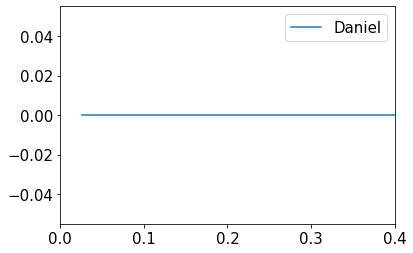

In [ ]:
br_file="2body_lep_321_-15.txt"
df1=pd.read_csv(f"{src_path}/Models/HNL/model/BR_for_Alec/{br_file}",delimiter='\t',engine='python',names=['mass','br'],index_col=False,skiprows=4)
mass1=df1['mass'].tolist()
br1=df1['br'].tolist()
plt.clf()
plt.plot(mass1,br1,label="Daniel")
plt.xlim(0,.4)
#plt.ylim(0,1)
plt.legend()
plt.show()


Let's first look at one benchmark scenario with $M_{N}=1$ GeV and $\epsilon=10^{-3.5}$ using the function `foresee.get_llp_spectrum()`. By default, the result are saved in the `model/LLP_spectra` directory. However, here set `save_file=False` since we don't want to save the results but set `do_plot=True` to plot them. 

In [ ]:
#plot = foresee.get_llp_spectrum(mass=1., coupling=10**-3.5, do_plot=True, save_file=False)

We can now produce a set of LLP spectra for various masses  (chosen to be equally spaced in log(mass)) and unit coupling and save them. 

In [ ]:
#works just time consuming
ikjdfd
'''masses = np.logspace(-1,1,20+1)
#masses = [1]
for mass in masses:
    foresee.get_llp_spectrum(mass=mass,coupling=1)'''

NameError: name 'ikjdfd' is not defined

## 4. Count Event Rate in Detector

Before counting the number of decays within the detector volume, let us specify the detector geometry. For this we need

- the `distance` from the IP in meter (default: 480)
- the `length` in meter (default: 5)
- the `luminosity` in units of fb^-1 (default: 3000)
- the `selection` depending in `x.x` and `x.y` (default: `np.sqrt(x.x**2 + x.y**2)< 1`)
- the decay `channels` which the detector can see (default: None, meaning all of them)

The default correspond to the FASER2 detector.

In [ ]:
distance, selection, length, luminosity, channels = 480, "np.sqrt(x.x**2 + x.y**2)< 1", 5, 3000, None
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

Let us look for one specific HNL mass $M_{N}=1$ GeV at how many particle decay inside the decay volume. This can be done using `get_events()` for which we need to specify again the mass and filename. Additionally, we can specify 

- the `couplings` for which we evaluate the event rate as numpy array (deault `np.logspace(-8,-3,51)`)
- the `preselectioncuts` when reading the LLP spectra in terms of momentum `p` and angle `th` (default: `th<0.01 and p>100`)
- the number `nsample` describing how many randomly choosen values of $\phi_{LLP}$ should sampled (default 1). This is only relevant for detectors that are not cylyndrical or not centered around the beam axis. 
- the production `modes` which should be considered
- the `energy` of the experiments

In [ ]:
output = foresee.get_events(mass=1, energy=energy, couplings=np.logspace(-5,0,6))
coups, ctaus, nsigs, momenta, weights = output
for coup,ctau,nsig in zip(coups, ctaus, nsigs):
    print ("epsilon =", '{:5.3e}'.format(coup), ": nsignal =", '{:5.3e}'.format(nsig))

epsilon = 1.000e-05 : nsignal = 8.436e-06
epsilon = 1.000e-04 : nsignal = 8.436e-02
epsilon = 1.000e-03 : nsignal = 8.418e+02
epsilon = 1.000e-02 : nsignal = 6.889e+06
epsilon = 1.000e-01 : nsignal = 1.111e+08
epsilon = 1.000e+00 : nsignal = 5.229e-43


The previous function also outputs the energy distribution of the HNL particles which decay inside the detector. Let's have a look at them.

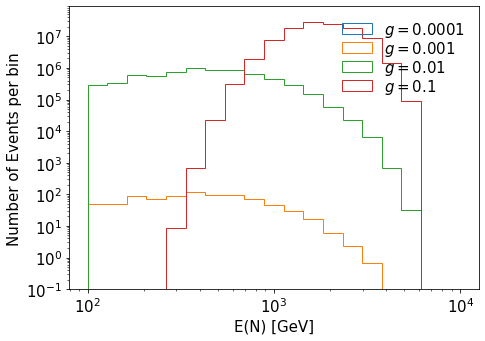

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
ens=[]
for coup,momentum,weight in zip(coups,momenta,weights):
    if sum(weight)<10**-3 : continue
    ax.hist([p.e for p in momentum],  weights=weight, bins=np.logspace(2,4, 20), histtype='step', label=r"$g=$"+str(coup)) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10**-1,9*10**7) 
    ax.set_xlabel("E(N) [GeV]") 
    ax.set_ylabel("Number of Events per bin") 
    ax.legend(frameon=False, labelspacing=0)
plt.tight_layout()
plt.show()

FORESEE also includes a function `write_events()` which obtains an unweighted sample of LLP decay events and saves them as a HEPMC file. For this function, we need to specify
- the `mass` and `coupling` of the LLP
- the collision `energy`
- the number of events `numberevent` that should be samples (optional, default=10)
- the `filename` of the output file (optional, default=`model/events/<mass>_<coupling>.hepmc`)
- the z-position (in meter) of the beginning of the decay volume (optional, default=0)
- a random `seed` (optional, default=None)
- the `decaychannels` for which the event should bbe written to file (optional, default=None meaning that all channels are written to file)

At the moment, FORESEE only supports 2-body LLP decays. For all other cases, including those where no final state information was specified when initiating the `Model`, the LLP will not be decayed. 

In [ ]:
foresee.write_events(filename="model/events/test.hepmc", mass=1, coupling=1.000e-02, 
    energy="14", numberevent=10, zfront=0)

/Users/felixkling/Documents/GitHub/FORESEE/src/foresee.py:1037: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  channels=np.array(channels).T


Let us have a look at a the output:

In [ ]:
f = open("model/events/test.hepmc", 'r')
file_contents = f.read()
print (file_contents)

HepMC::Version 2.06.09
HepMC::IO_GenEvent-START_EVENT_LISTING
E 0 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 689565.3023301548 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 251.3516300901 69.8444642807 1789.1647076574 0 1 0 0
P 1 32 0.1144909564 0.0318142338 218.6405517227 218.6428708601 1.0 1 0 0 -1 0
E 1 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 689565.3023301548 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 -467.94974992 623.3552811867 2115.8704623416 0 1 0 0
P 1 32 -0.2028812033 0.2702577991 208.1056301169 208.1083071057 1.0 1 0 0 -1 0
E 2 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 689565.3023301548 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 884.0975641757 -127.6557767214 4852.3915469523 0 1 0 0
P 1 32 0.545374419 -0.0787471857 296.0982268377 296.1004281841 1.0 1 0 0 -1 0
E 3 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 689565.3023301548 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 -303.604467263 -106.847827549 2196.6419808459 0 1 0 0
P 1 32 -0.3332660534 -0.1172866596 526.8950983414 526.8961657467 1.0 1 0 0 -1 0
E 4 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U 

## 5. Parameter Scan

In the following, we will get the LLP sensitivity reach for different detector configuraions. As an example, we show the FASER2 reach for dark photons for 3 scenarios. We just need to loop over different masses and use the previously introduced funtion `get_events`. The results will be written into a `.npy` file that we can store and plot later.

- the nominal/default setup

In [ ]:
#masses
masses = np.logspace(-1,1,20+1)

#specify setup
luminosity, distance = 3000 , 480
setup, selection, channels = "default", "np.sqrt(x.x**2 + x.y**2)< 1", None
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ = foresee.get_events(mass=mass, energy=energy,couplings=np.logspace(-5,0,50+1))
    list_nevents.append(nevents)  
    
#save results
np.save(model.modelpath+"model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

/Users/felixkling/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## 6. Plot the Results

Now let's plot the results. We first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [ ]:
setups = [
    ["14TeV_default.npy",    "default"  , "red",     "solid", 0., 3],
]

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation)

In [ ]:
bounds = [ 
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [ ]:
projections = [
    ["limits_SHiP_el.txt",      "dodgerblue" , "SHiP"      , 3   , 0.0001 , 0  ],
    ["limits_NA62_el.txt",      "blue"       , "NA62"      , 1   , 0.0002 , 0  ],
    ["limits_DUNE_el.txt",      "cyan"       , "DUNE"      , 0.6 , 0.00009, 0  ],
    ['limits_CODEX_el.txt',     "purple"     , "CODEX"     , 2e-1, 0.0003 , 0  ],
    ["limits_MATHUSLA_el.txt",  "deepskyblue", "MATHUSLA"  , 0.3 , 0.0001 , 0  ],
    ["limits_FASER2_el.txt",    "magenta"    , "FASER2 OLD", 0.3 , 0.001  , 0  ]
]

Finally, we can plot everything using `foresee.plot_reach()`. It returns a matplotlib instance, to which we can add further lines and which we can show or save. Below, we add the dark matter relict target line for a specific benchmark.

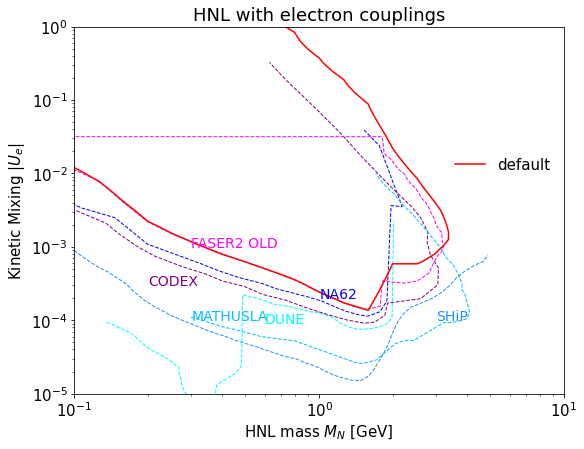

In [ ]:
plot = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="HNL with Electron Couplings",
    xlims = [1e-1, 10], 
    ylims = [1e-5, 1 ],
    xlabel=r"HNL mass $M_{N}$ [GeV]", 
    ylabel=r"Kinetic Mixing $|U_{e}|$",
    legendloc=(1,0.68),
    figsize=(8,6),
)
plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
#plot.savefig("/Users/alechewitt/Desktop/Figure.pdf")
plot.show()

$\color{red}{\text{      ... THE OLD (MAGENTA) and NEW (RED) LINES LOOK SIMILAR}}$
$\color{red}{\text{      ... THE DIFFERENCED RE PROABLY DUE TO DIFFERENT CHARM PRODUCTION AND MISSING PROD. CHANNELS}}$

## 7. Export Contours

It might also be useful to extract the contours lines, and save them as a text file. This can be done using the `extract_contours()` function. As example, let us export the FASER2 line. 

In [ ]:
foresee.extract_contours(
    inputfile="model/results/14TeV_default.npy", 
    outputfile="model/lines/limits_FASER2.txt"
)

## Plot Production Cross Section 

We also can plot the production cross section as a function of the particle mass via `foresee.plot_production`. We do this below to show the production rate associated with different channels (commenting out the subleading channels): 

In [ ]:
masses = [0.1, 0.2, 0.3, 0.7, 1, 1.2, 1.4, 2, 3 ]
productions = [
    ["2body_411_-11"     , None      , "firebrick"   , r"$D^+ \to e^+ N$"   ],   
    ["2body_431_-11"     , None      , "red"         , r"$D_s^+ \to e^+ N$" ],   
    ["2body_521_-11"     , [0.5,10]  , "orange"      , r"$B^+ \to e^+ N$"   ],  
    ["2body_541_-11"     , [0.5,10]  , "gold"        , r"$B_c^+ \to e^+ N$" ],   
    ["3body_411_-311_-11", None      , "blue"        , r"$D^+ \to \bar{K}^0 e^+ N$" ],   
    ["3body_421_-321_-11", None      , "deepskyblue" , r"$D^0 \to K^- e^+ N$"       ], 
    ["3body_511_-411_-11", [0.5,10]  , "green"       , r"$B^0 \to D^- e^+ N$"       ], 
    ["3body_531_-431_-11", [0.5,10]  , "limegreen"   , r"$B_s^+ \to D_s^- e^+ N$"   ], 
]

foresee.plot_production(
    masses = masses, 
    productions = productions,
    condition="True", 
    xlims=[0.1,30],ylims=[10**0,10**10], 
    xlabel=r"HNL Mass [GeV]", 
    ylabel=r"Production Rate $\sigma/\epsilon^2$ [pb]",
    legendloc=(1.02,1.02),
    fs_label=12,
    title="All HNLs",
)

plot.savefig("Figure_HNL_Prod_All.pdf")
plot.show()

In [14]:
#helpful functions for creating files and reading files, etc.
#takes a number and chops off part of it according to the precision, or delta

def chop(expr, delta=10**-2):
    return np.ma.masked_inside(expr, -delta, delta).filled(0)
#this portion will take a branching fraction and write to a file in the form m br
#for the decays of HNL, takes a branching ratio and creates a file of mass br
def write_m_br_file(br,mass_produced,filename="model/pi_nu.txt",start_mass=0,end_mass=10,write_pid=False,pid1_t=None,pid2_t=None,pid3_t=None):
    f = open(filename, "w+")
    f.close()
    f = open(filename, "a")
    mass=0.01
    delm=0.01
    if write_pid==True:
        if pid3_t!=None:
            f.write(pid1_t + "\t" + pid2_t + "\t" + pid3_t + "\n")
        if pid3_t==None:
            f.write(pid1_t + "\t" + pid2_t + "\t" + "none" + "\n")
    if write_pid==False:
        f.write("None" + "\n")
    steps=int((10-0)/0.01)-1
    for n in range(steps):
        if mass>mass_produced and mass>start_mass and mass<end_mass:
            f.write(" {: <10} {: <10}\n".format(*['%.2f' % mass,eval(br)]))
        else:
            f.write(" {: <10} {: <10}\n".format(*['%.2f' % mass,0]))
        mass=chop(mass+delm)
    f.close()
    print(filename + ' created...')

#same as write_m_br_file except for mass between, start_mass, end_mass is for the starting mass for br_had and ending mass for br_had
def write_m_br_had_file(br,br_had,mass_produced,start_mass,end_mass,filename="model/pi_nu.txt"):
    f = open(filename, "w+")
    f.close()
    f = open(filename, "a")
    mass=start_mass
    delm=.01
    steps=int((end_mass-start_mass)/.01)+1
    for n in range(steps):
        if mass>mass_produced:
            f.write(" {: <10} {: <10}\n".format(*['%.2f' % mass,eval(br_had)]))
        else:
            f.write(" {: <10} {: <10}\n".format(*['%.2f' % mass,0]))
        mass=chop(mass+delm)
    mass=end_mass
    delm=.01
    steps=int((10-end_mass)/.01)+1
    for n in range(steps):
        if mass>mass_produced:
            f.write(" {: <10} {: <10}\n".format(*['%.2f' % mass,eval(br)]))
        else:
            f.write(" {: <10} {: <10}\n".format(*['%.2f' % mass,0]))

        mass=chop(mass+delm)
    f.close()
    print(filename + 'file created...')

#this is for the decay N->nu_l1 l2 l2
def write_m_brm_file(filename="model/pi_nu.txt"):
    f = open(filename, "w+")
    f.close()
    f = open(filename, "a")
    mass=.01
    br=bra_nul1_l2_l2(mass,l1,l2)+"*6.58*10**-14"
    delm=.01
    steps=int(10/.01)-1
    for n in range(steps):
        f.write(" {: <10} {: <10}\n".format(*['%.2f' % mass,eval(br)]))
        mass=chop(mass+delm)
    f.close()
    print('file created...')

def calc_m_tau(filename="model/tau_GeV.txt"):
    br_files=os.listdir("model/width/")
    lep_file_char="width_3body_lep"
    had_file_char="width_3body_inc"
    counter=0
    for n in range(len(br_files)):
        if br_files[n][0:len(lep_file_char)]==lep_file_char or br_files[n][0:len(had_file_char)]==had_file_char:
            counter+=1
            file_name=br_files[n]
            m_width_df_temp = pd.read_csv(f"model/width/{file_name}",delimiter='       ',engine='python',names=['mass','width'],index_col=False)
            m_width_df_temp['width'] = m_width_df_temp['width'].fillna(0)
            if counter==1:
                width=np.array(m_width_df_temp['width'].tolist())
            if counter!=1:
                width_temp=np.array(m_width_df_temp['width'].tolist())
                width+= width_temp
    mass=np.array(m_width_df_temp['mass'].tolist())
    tau=1/width
    return(mass,tau)

def calc_m_ctau(filename="model/ctau.txt"):
    br_files=os.listdir("model/width/")
    lep_file_char="width_3body_lep"
    had_file_char="width_2body_ex"
    hadf_file_char="width_3body_inc"
    counter=0
    for n in range(len(br_files)):
        if br_files[n][0:len(lep_file_char)]==lep_file_char or br_files[n][0:len(had_file_char)]==had_file_char or br_files[n][0:len(hadf_file_char)]==hadf_file_char:
            counter+=1
            file_name=br_files[n]
            m_width_df_temp = pd.read_csv(f"model/width/{file_name}",delimiter='       ',engine='python',names=['mass','width'],index_col=False)
            m_width_df_temp['width'] = m_width_df_temp['width'].fillna(0)
            if counter==1:
                width=np.array(m_width_df_temp['width'].tolist())
            if counter!=1:
                width_temp=np.array(m_width_df_temp['width'].tolist())
                width+= width_temp
    mass=np.array(m_width_df_temp['mass'].tolist())
    ctau=((1/(width*10**-7))*((6.582122*pow(10.,-25.))))*3*10**8
    return(mass,ctau)

def write_m_ctau_file(filename="model/ctau.txt"):
    br_files=os.listdir("model/width/")
    lep_file_char="width_3body_lep"
    had_file_char="width_2body_ex"
    hadf_file_char="width_3body_inc"
    counter=0
    for n in range(len(br_files)):
        if br_files[n][0:len(lep_file_char)]==lep_file_char or br_files[n][0:len(had_file_char)]==had_file_char or br_files[n][0:len(hadf_file_char)]==hadf_file_char:
            counter+=1
            file_name=br_files[n]
            m_width_df_temp = pd.read_csv(f"model/width/{file_name}",delimiter='       ',engine='python',names=['mass','width'],index_col=False,skiprows=1)
            m_width_df_temp['width'] = m_width_df_temp['width'].fillna(0)
            if counter==1:
                width=np.array(m_width_df_temp['width'].tolist())
            if counter!=1:
                width_temp=np.array(m_width_df_temp['width'].tolist())
                width+= width_temp
    mass=np.array(m_width_df_temp['mass'].tolist())
    ctau=((1/(width*10**-7))*((6.582122*pow(10.,-25.))))*3*10**8
    f = open(filename, "w+")
    f.close()
    f = open(filename, "a")
    if len(mass)!=len(ctau):
        print("the masses dont match the shape of ctau!!!")
    for n in range(len(mass)):
        f.write(" {: <10} {: <10}\n".format(*['%.2f' % mass[n],ctau[n]]))
    f.close()

def read_m_br(characteristic):
    br_files=os.listdir("model/width/")
    width=[]
    counter=0
    for n in range(len(br_files)):
        if br_files[n][0:len(characteristic)]==characteristic:
            counter+=1
            file_name=br_files[n]
            m_width_df_temp = pd.read_csv(f"model/width/{file_name}",delimiter='       ',engine='python',names=['mass','width'],index_col=False)
            if counter==1:
                width=np.array(m_width_df_temp['width'].tolist())
            if counter!=1:
                width_temp=np.array(m_width_df_temp['width'].tolist())
                width+= width_temp
    mass=np.array(m_width_df_temp['mass'].tolist())
    return (mass,width,counter)

#"/Users/alechewitt/Desktop/felix_pts.csv"
def read_digitized_file(filename="/Users/alechewitt/Desktop/felix_pts.csv",name_col1="x",name_col2="y"):
    x_y_df = pd.read_csv(filename,delimiter=',',engine='python',names=[name_col1,name_col2],index_col=False)
    x=np.array(x_y_df[name_col1].tolist())[4:]
    y=np.array(x_y_df[name_col2].tolist())[4:]
    x=[float(a) for a in x]
    y=[float(a) for a in y]
    return(x,y)

def read_file(filename,name_col1="x",name_col2="y"):
    x_y_df = pd.read_csv(filename,delimiter='       ',engine='python',names=[name_col1,name_col2],index_col=False)
    x=np.array(x_y_df[name_col1].tolist())[4:]
    y=np.array(x_y_df[name_col2].tolist())[4:]
    return(x,y)

def convert_width_to_br():
    br_files=os.listdir("model/width/")
    ctau=pd.read_csv(f"model/ctau.txt",delimiter='       ',engine='python',names=['mass','ctau'],index_col=False)
    for n in range(len(br_files)):
        file_name=br_files[n]
        m_width_df = pd.read_csv(f"model/width/{file_name}",delimiter='       ',engine='python',names=['mass','width'],index_col=False,skiprows=1)
        m_width_df['width']=m_width_df['width']*ctau['ctau']*10**-7/(((6.582122*pow(10.,-25.)))*3*10**8)
        numpy_array = m_width_df.to_numpy()
        new_file_name="br"+br_files[n][len("width"):]
        np.savetxt(f"model/br/{new_file_name}", numpy_array,delimiter='       ')

def convert_width_to_br_temp(path="model/width_temp/"):
    br_files=os.listdir(path)
    ctau=pd.read_csv(f"model/ctau.txt",delimiter='       ',engine='python',names=['mass','ctau'],index_col=False)
    for n in range(len(br_files)):
        file_name=br_files[n]
        m_width_df = pd.read_csv(path + f"{file_name}",delimiter='       ',engine='python',names=['mass','width'],index_col=False)
        m_width_df['width']=m_width_df['width']*ctau['ctau']*10**-7/(((6.582122*pow(10.,-25.)))*3*10**8)
        numpy_array = m_width_df.to_numpy()
        new_file_name="br"+br_files[n][len("width"):]
        np.savetxt(f"model/br_temp/{new_file_name}", numpy_array,delimiter='       ')



#input path to given folder and it removes all files in that folder
def remove_files_from_folder(path):
    files = glob.glob(path)
    for f in files:
        os.remove(f)


def add_br_files(files,br_or_width):
    folder=f"{br_or_width}"
    br_files=os.listdir(f"model/{folder}/")
    counter=0
    for n in range(len(br_files)):
        for m in range(len(files)):
            if br_files[n][0:len(files[m])] in files:
                counter+=1
                file_name=br_files[n]
                m_width_df_temp = pd.read_csv(f"model/{folder}/{file_name}",delimiter='       ',engine='python',names=['mass','width'],index_col=False,dtype='float64',skiprows=1)
                m_width_df_temp['width'] = m_width_df_temp['width'].fillna(0)
                if counter==1:
                    width=np.array(m_width_df_temp['width'].tolist())
                if counter!=1:
                    width_temp=np.array(m_width_df_temp['width'].tolist())
                    width+= width_temp
                    for l in range(len(width_temp)):
                        if width_temp[l]<0:
                            print(file_name)
                            pass
    mass=np.array(m_width_df_temp['mass'].tolist())
    return(mass,width)
    





In [15]:
#list of particles for the decay channels, start and end masses
GF=1.166378*10**(-5)
#xw=0.231
leptons=["11","13","15"]
nu_alpha=["12","14","16"]
pid_start="111"
pid_end="331"
self=model
start_mass=self.masses(pid_start)
end_mass=self.masses(pid_end)
end_mass=10


quarks_u_symbols=["u","c","t"]
quarks_u=        ["2","4"]          #skipped top since it is heavy
quarks_d_symbols=["d","s","b"]   
quarks_d=        ["1","3","5"]


charged_pseudo_symb=["K+","pi+","D+","D+s","B+"]
charged_pseudo=["321","211","411","431","521"]


neutral_pseudo_symb=["K0","\eta","\eta'","pi0","D0"]
neutral_pseudo=["311","221","331","111","421"]


charged_vec_symb=["K*+","rho+","D*+","D*s+"]
charged_vec=["323","213","413","433"]


neutral_vec_symb=["K*0","\omega","\rho0","phi","J/psi","D*0"]
neutral_vec=["313","223","113","333","443","423"]


In [19]:
#functions to calculate widths

#auxiliary functions 
lamda=lambda a,b,c: a**2+b**2+c**2-2*a*b-2*b*c-2*c*a
I1_integrand=lambda s,x,y,z: (12/s)*(s-x**2-y**2)*(1+z**2-s)*np.sqrt(lamda(s,x**2,y**2))*np.sqrt(lamda(1,s,z**2))
I2_integrand=lambda s,x,y,z: (24*y*z/s)*(1+x**2-s)*np.sqrt(lamda(s,y**2,z**2))*np.sqrt(lamda(1,s,x**2))
delta=lambda l1,l2: 1 if l1==l2 else 0
xw=f"(0.231)" #xw=sin(theta_w)^2
x=0
xq=f"(self.masses(pid1)/mass)"
y=xq
z=xq





#for N->l_{\alpha \neq \beta}^- l_beta^+ nu_beta
def calc_br_la_lb_nub(pid1,pid2,pid3):
    yl1=f"(self.masses(pid1)/mass)"
    yl2=f"(self.masses(pid2)/mass)"
    ynul2=f"(self.masses(pid3)/mass)"
    x=yl1
    y=ynul2
    z=yl2
    I1=f"quad(I1_integrand,({x}+{y})**2,(1-{z})**2,args=({x},{y},{z}))[0]"
    br_la_lb_nub="2*"+f"(hnl.vcoupling[str(abs(int(pid1)))]**2*GF**2*mass**5/(192*np.pi**3))*{I1}*(1-delta(abs(int(pid1)),abs(int(pid2))))"
    return(br_la_lb_nub)

#for N->l_beta^+ l_beta^- nu_alpha 
def calc_br_lb_lb_nua(pid1,pid2,pid3):
    delta=lambda l1,l2: 1 if l1==l2 else 0
    if pid2=="11":
        l2=1
    if pid2=="13":
        l2=2
    if pid2=="15":
        l2=3
    if pid3=="12":
        l1=1
    if pid3=="14":
        l1=2
    if pid3=="16":
        l1=3
    xw=f"(0.231)"

    gL=f"(-(1/2)+{xw})"
    gR=f"{xw}"
    x=f"0"
    y=f"(self.masses(pid2)/mass)"
    z=y
    I1=f"quad(I1_integrand,({x}+{y})**2,(1-{z})**2,args=({x},{y},{z}))[0]"
    I2=f"quad(I2_integrand,({y}+{z})**2,(1-{x})**2,args=({x},{y},{z}))[0]"
    coupling=f"hnl.vcoupling[str(abs(int(pid3))-1)]"
    br_lb_lb_nua="2*"+f"({coupling}**2*GF**2*mass**5/(192*np.pi**3))*(({gL}*{gR}+{delta(l1,l2)}*{gR})*{I2}+({gL}**2+{gR}**2+{delta(l1,l2)}*(1+2*{gL}))*{I1})"
    return(br_lb_lb_nua)

#for N->U bar{D} l_alpha^-
def calc_br_u_bd_l(pid1,pid2,pid3):
    xd=f"(self.masses(pid2)/mass)"
    xu=f"(self.masses(pid1)/mass)"
    xl=f"(self.masses(pid3)/mass)"
    x=xl
    y=xu
    z=xd
    I=f"quad(I1_integrand,({x}+{y})**2,(1-{z})**2,args=({x},{y},{z}))[0]"
    coupling=f"hnl.vcoupling[str(abs(int(pid3)))]"
    #this should be multiplied by 2 
    br_u_d_l="2*"+f"(hnl.VHHp(pid1,pid2)**2*GF**2*mass**5*{coupling}**2/(64*np.pi**3))*{I}"
    return(br_u_d_l)

#HNL decays 3 body (quarks)
#inclusive decays
#for N-> q \bar{q} nu_l
def calc_br_q_bq_nu(pid1,pid3):
    if pid1 in quarks_u:
        gL=f"(1/2-(2/3)*{xw})"
        gR=f"(-(2/3)*{xw})" #article had 2 g_R^U so I assumed one was supposed to have a D
    if pid1 in quarks_d:
        gL=f"(-1/2+(1/3)*{xw})"
        gR=f"((1/3)*{xw})"
    I1=f"quad(I1_integrand,({x}+{y})**2,(1-{z})**2,args=({x},{y},{z}))[0]"
    I2=f"quad(I2_integrand,({y}+{z})**2,(1-{x})**2,args=({x},{y},{z}))[0]"
    coupling=f"hnl.vcoupling[str(abs(int(pid3))-1)]"
    #no factor of 2 since the charge conjugate process is the same process (I think the source already included factor of 2 here)
    #was a factor of 1/2 here
    br_q_bq_nu=f"({coupling}**2*GF**2*mass**5/(32*np.pi**3))*({gL}*{gR}*{I2}+({gL}**2+{gR}**2)*{I1})"
    return(br_q_bq_nu)

#for N->P+ l- 
def calc_br_P_l(pid1,pid2):
    FP=lambda x,y: f"np.sqrt(lamda(1,{x}**2,{y}**2))*((1+{x}**2)*(1+{x}**2-{y}**2)-4*{x}**2)"
    yP=f"(self.masses(pid1)/mass)"
    yl=f"(self.masses(pid2)/mass)"
    coupling=f"hnl.vcoupling[str(abs(int(pid2)))]"
    #no factor of 2 added (probably should add)
    br_P_l="2*"+f"({coupling}**2*GF**2*mass**3*hnl.fH(pid1)**2*hnl.VH(pid1)**2/(16*np.pi))*{FP(yl,yP)}"
    return(br_P_l)

def calc_br_P0_nu(pid1,pid2):
    coupling=f"hnl.vcoupling[str(abs(int(pid2))-1)]"
    #no factor of 2 added for conjugate process, one has already been added
    yP=f"(self.masses(pid1)/mass)"
    br_P0_nu=f"({coupling}**2*GF**2*mass**3*(hnl.fH(pid1))**2/(64*np.pi))*(1-{yP}**2)**2"
    return(br_P0_nu)

#for N->V+ l-
def calc_br_V_l(pid1,pid2): 
    FV=lambda x,y: f"np.sqrt(lamda(1,{x}**2,{y}**2))*((1-{x}**2)**2+(1+{x}**2)*{y}**2-2*{y}**4)"
    #it was self.masses(pid1)
    yV=f"(self.masses(pid1)/mass)"
    yl=f"(self.masses(pid2)/mass)"
    coupling=f"hnl.vcoupling[str(abs(int(pid2)))]"
    #no factor of 2 added, should probably add it though
    br_V_l="2*"+f"({coupling}**2*GF**2*mass**3*hnl.fH(pid1)**2*hnl.VH(pid1)**2/(16*np.pi))*{FV(yl,yV)}"
    return(br_V_l)

#for N->V0 nu
def calc_br_V0_nu(pid1):
    xw=f"(0.231)"
    coupling=f"hnl.vcoupling[str(abs(int(pid2))-1)]"
    yV=f"(self.masses(pid1)/mass)"
    if abs(int(pid1))==313 or abs(int(pid1)==333):
        kv=f"((-1/4)+{xw}/3)"
    if abs(int(pid1))==223 or abs(int(pid1))==113:
        kv=f"({xw}/3)"
    if abs(int(pid1))==423 or abs(int(pid1))==443:
        kv=f"((1/4)-2*{xw}/3)"
    #no need to multiply by 2 for conjugate process, since it is already accounted for
    br_V0_nu=f"({coupling}**2*GF**2*mass**3*hnl.fH(pid1)**2*{kv}**2/(2*np.pi))*(1-{yV}**2)**2*(1+2*{yV}**2)"
    return(br_V0_nu)

In [20]:
#list of mesons which the HNL can decay to. (need to delete)
#only 3 body decays suggested by Jonathan


#removes br files, since this part will create them again
path=f"{src_path}/Models/HNL/model/br/*"
remove_files_from_folder(path)

#remove width files, so it can update it
path=f"{src_path}/Models/HNL/model/width/*"
remove_files_from_folder(path)

#remove ctau file, so it can update it
path=f"{src_path}/Models/HNL/model/ctau.txt"
if exists(path)==True:
    os.remove(f"{src_path}/Models/HNL/model/ctau.txt")


##########creates width files############

#for N->sum_{alpha beta} nu_alpha bar{nu}_beta nu_beta
pid1,pid2,pid3=["12","14","16"]
mass_produced=self.masses(pid1)+self.masses(pid2)+self.masses(pid3)
#multiply by 2 to account for charge conjugate process
br_nu_bnu_nu="2*"+f"(GF**2*mass**5/(192*np.pi**3))*(hnl.vcoupling[str(abs(int(pid1))-1)]**2+hnl.vcoupling[str(abs(int(pid2))-1)]**2+hnl.vcoupling[str(abs(int(pid3))-1)]**2)"
write_m_br_file(br_nu_bnu_nu,mass_produced,filename=f"model/width/width_3body_lep_sum_nua_bnub_nub.txt")
print('3 body N->sum_{alpha beta} nu_alpha bar{nu}_beta nu_beta done...')


#for N->l_{\alpha \neq \beta}^- l_beta^+ nu_beta
for a in range(len(leptons)):
    for b in range(len(leptons)):
        if a!=b:
            pid1=leptons[a]
            pid2=leptons[b]
            pid2="-"+pid2
            pid3=nu_alpha[b]
            mass_produced=(self.masses(pid1)+self.masses(pid2)+self.masses(pid3))
            br_la_lb_nub=calc_br_la_lb_nub(pid1,pid2,pid3)
            write_m_br_file(br_la_lb_nub,mass_produced,filename=f"model/width/width_3body_lep_la_lb_nub_{pid1}_{pid2}_{pid3}.txt", write_pid=True,pid1_t=pid1,pid2_t=pid2, pid3_t=pid3)
print('3 body N->l_{\alpha \neq \beta}^- l_beta^+ nu_beta done...')


#for N->l_beta^+ l_beta^- nu_alpha using daniels formula
for b in range(len(leptons)):
    for a in range(len(nu_alpha)):
        pid1=leptons[b]
        pid1="-"+pid1
        pid2=leptons[b]
        pid3=nu_alpha[a]
        mass_produced=self.masses(pid1)+self.masses(pid2)+self.masses(pid3)
        br_lb_lb_nua=calc_br_lb_lb_nua(pid1,pid2,pid3)
        write_m_br_file(br_lb_lb_nua,mass_produced,filename=f"model/width/width_3body_lep_lb_lb_nua_{pid1}_{pid2}_{pid3}.txt", write_pid=True,pid1_t=pid1,pid2_t=pid2, pid3_t=pid3)
print('3 body N->l_beta^+ l_beta^- nu_alpha done...')


#HNL decays 3 body (quarks)
#inclusive decays
#for N->U bar{D} l_alpha^-'
for u in range(len(quarks_u)):
    for d in range(len(quarks_d)):
        for a in range(len(leptons)):
            pid1=quarks_u[u]
            pid2=quarks_d[d]
            pid3=leptons[a]
            mass_produced=self.masses(pid1)+self.masses(pid2)+self.masses(pid3)
            br_u_d_l=calc_br_u_bd_l(pid1,pid2,pid3)
            write_m_br_file(br_u_d_l,mass_produced,filename=f"model/width/width_3body_inc_u_d_l_{pid1}_{pid2}_{pid3}.txt",start_mass=end_mass,end_mass=10, write_pid=True,pid1_t=pid1,pid2_t=pid2, pid3_t=pid3)
print('3 body N->U bar{D} l_alpha^- done...')


#for N-> q \bar{q} nu_l
for q in range(len(quarks_u+quarks_d)):
    pid1=(quarks_u+quarks_d)[q]
    pid2="-"+pid1
    for a in range(len(nu_alpha)):
        pid3=nu_alpha[a]
        mass_produced=self.masses(pid1)+self.masses(pid2)+self.masses(pid3)
        br_q_bq_nu=calc_br_q_bq_nu(pid1,pid3)
        write_m_br_file(br_q_bq_nu,mass_produced,filename=f"model/width/width_3body_inc_u_bu_l_{pid1}_{pid2}_{pid3}.txt",start_mass=start_mass,end_mass=10, write_pid=True,pid1_t=pid1,pid2_t=pid2, pid3_t=pid3)
print('3 body N-> q \bar{q} nu_alpha done...')


#pseudoscalar and vector decays
#for N-> P+ l-
for n in range(len(charged_pseudo)):
    pid1=charged_pseudo[n]
    for m in range(len(leptons)):
        if int(pid1)<0:
            pid2="-"+leptons[m]
        else:
            pid2=leptons[m]
        br_P_l=calc_br_P_l(pid1,pid2)
        mass_produced=self.masses(pid1)+self.masses(pid2)
        write_m_br_file(br_P_l,mass_produced,filename=f"model/width/width_2body_ex_P_{pid1}_{pid2}.txt",start_mass=start_mass,end_mass=end_mass, write_pid=True,pid1_t=pid1,pid2_t=pid2)
print("N->P+ l- done...")


#for N->P0 nu
for n in range(len(neutral_pseudo)):
    pid1=neutral_pseudo[n]
    for m in range(len(nu_alpha)):
        if int(pid1)<0:
            pid2="-"+nu_alpha[m]
        else:
            pid2=nu_alpha[m]
        mass_produced=self.masses(pid1)+self.masses(pid2)
        br_P0_nu=calc_br_P0_nu(pid1,pid2)
        write_m_br_file(br_P0_nu,mass_produced,filename=f"model/width/width_2body_ex_P0_{pid1}_{pid2}.txt",start_mass=start_mass,end_mass=end_mass, write_pid=True,pid1_t=pid1,pid2_t=pid2)
print("N->P0 nu done...")


#for N->V+ l-
for n in range(len(charged_vec)):
    pid1=charged_vec[n]
    for m in range(len(leptons)):
        if int(pid1)<0:
            pid2="-"+leptons[m]
        else:
            pid2=leptons[m]
        mass_produced=self.masses(pid1)+self.masses(pid2)
        br_V_l=calc_br_V_l(pid1,pid2)
        write_m_br_file(br_V_l,mass_produced,filename=f"model/width/width_2body_ex_V_{pid1}_{pid2}.txt",start_mass=start_mass,end_mass=end_mass, write_pid=True,pid1_t=pid1,pid2_t=pid2)
print("N->V+ l- done...")


#for N->V0 nu
for n in range(len(neutral_vec)):
    pid1=neutral_vec[n]
    br_V0_nu=calc_br_V0_nu(pid1)
    for m in range(len(nu_alpha)):
        if int(pid1)<0:
            pid2="-"+nu_alpha[m]
        else:
            pid2=nu_alpha[m]
        mass_produced=self.masses(pid1)+self.masses(pid2)
        write_m_br_file(br_V0_nu,mass_produced,filename=f"model/width/width_2body_ex_V0_{pid1}_{pid2}.txt",start_mass=start_mass,end_mass=end_mass, write_pid=True,pid1_t=pid1,pid2_t=pid2)


print("N->V0 nu done...")
write_m_ctau_file(filename="model/ctau.txt")
print("ctau.txt created...")
convert_width_to_br()
print("br files created...")

model/width/width_3body_lep_sum_nua_bnub_nub.txt created...
3 body N->sum_{alpha beta} nu_alpha bar{nu}_beta nu_beta done...
model/width/width_3body_lep_la_lb_nub_11_-13_14.txt created...
model/width/width_3body_lep_la_lb_nub_11_-15_16.txt created...
model/width/width_3body_lep_la_lb_nub_13_-11_12.txt created...
model/width/width_3body_lep_la_lb_nub_13_-15_16.txt created...
model/width/width_3body_lep_la_lb_nub_15_-11_12.txt created...
model/width/width_3body_lep_la_lb_nub_15_-13_14.txt created...
3 body N->l_{lpha 
eqeta}^- l_beta^+ nu_beta done...
model/width/width_3body_lep_lb_lb_nua_-11_11_12.txt created...
model/width/width_3body_lep_lb_lb_nua_-11_11_14.txt created...
model/width/width_3body_lep_lb_lb_nua_-11_11_16.txt created...
model/width/width_3body_lep_lb_lb_nua_-13_13_12.txt created...
model/width/width_3body_lep_lb_lb_nua_-13_13_14.txt created...
model/width/width_3body_lep_lb_lb_nua_-13_13_16.txt created...
model/width/width_3body_lep_lb_lb_nua_-15_15_12.txt created...
mo

In [ ]:
#this part analyzes how well inclusive and exclusive methods agree (redo)

#removes br_temp files, since this part will create them again
path=f"{src_path}/Models/HNL/model/br_temp/*"
remove_files_from_folder(path)

#remove width files
path=f"{src_path}/Models/HNL/model/width_temp/*"
remove_files_from_folder(path)

#HNL decays 3 body (quarks)
#for N->U bar{D} l_alpha^-
#pid1=U; pid2=bar{D}; pid3=l_alpha^-
from scipy.integrate import quad
#pid1="2"
#pid2="1"
#pid3="11"
quarks_u_symbols=["u","c","t"]
quarks_u=        ["2","4"]
quarks_d_symbols=["d","s","b"]      #skipped top quark since it is very heavy
quarks_d=        ["1","3","5"]
pid1="211"
#mass=1
#br_H_l=f"(coupling**2/(16*np.pi))*GF**2*hnl.VH(pid1)**2*hnl.fH(pid1)**2*mass**3*((1-self.masses(pid2)**2/mass**2)**2-(self.masses(pid1)**2/mass**2)*(1+self.masses(pid2)**2/mass**2))*np.sqrt((1-(self.masses(pid1)-self.masses(pid2))**2/mass**2)*(1-(self.masses(pid1)+self.masses(pid2))**2/mass**2))"
'''I_integrand=lambda s,x,y,z: (12/s)*(s-x**2-y**2)*(1+z**2-s)*np.sqrt(lamda(s,x**2,y**2))*np.sqrt(lamda(1,s,z**2))
lamda=lambda a,b,c: a**2+b**2+c**2-2*a*b-2*b*c-2*c*a
def calc_br_u_bd_l(pid1,pid2,pid3):
    xd=f"(self.masses(pid2)/mass)"
    xu=f"(self.masses(pid1)/mass)"
    xl=f"(self.masses(pid3)/mass)"
    x=xl
    y=xu
    z=xd
    I=f"quad(I_integrand,({x}+{y})**2,(1-{z})**2,args=({x},{y},{z}))[0]"
    coupling=f"hnl.vcoupling[str(abs(int(pid3)))]"
    #this should be multiplied by 2 
    br_u_d_l="2*"+f"(hnl.VHHp(pid1,pid2)**2*GF**2*mass**5*{coupling}**2/(64*np.pi**3))*{I}"
    return(br_u_d_l)'''

for u in range(len(quarks_u)):
    for d in range(len(quarks_d)):
        for a in range(len(leptons)):
            pid1=quarks_u[u]
            pid2=quarks_d[d]
            pid3=leptons[a]
            mass_produced=self.masses(pid1)+self.masses(pid2)+self.masses(pid3)
            br_u_d_l=calc_br_u_bd_l(pid1,pid2,pid3)
            write_m_br_file(br_u_d_l,mass_produced,filename=f"model/width_temp/width_temp_3body_inc_u_d_l_{pid1}_{pid2}_{pid3}.txt",start_mass=0,end_mass=10)
print('3 body N->U bar{D} l_alpha^- done...')

#HNL decays 3 body (quarks)
#inclusive decays
#for N-> q \bar{q} nu_l
nu_alpha=["12","14","16"]
'''GF=1.166378*10**(-5)
lamda=lambda a,b,c: a**2+b**2+c**2-2*a*b-2*b*c-2*c*a
x=0
xq=f"(self.masses(pid1)/mass)"
y=xq
z=xq
xw=f"(0.231)" #xw=sin(theta_w)^2
I1_integrand=lambda s,x,y,z: (12/s)*(s-x**2-y**2)*(1+z**2-s)*np.sqrt(lamda(s,x**2,y**2))*np.sqrt(lamda(1,s,z**2))
I2_integrand=lambda s,x,y,z: (24*y*z/s)*(1+x**2-s)*np.sqrt(lamda(s,y**2,z**2))*np.sqrt(lamda(1,s,x**2))

def calc_br_q_bq_nu(pid1,pid3):
    if pid1 in quarks_u:
        gL=f"(1/2-(2/3)*{xw})"
        gR=f"(-(2/3)*{xw})" #article had 2 g_R^U so I assumed one was supposed to have a D
    if pid1 in quarks_d:
        gL=f"(-1/2+(1/3)*{xw})"
        gR=f"((1/3)*{xw})"
    I1=f"quad(I1_integrand,({x}+{y})**2,(1-{z})**2,args=({x},{y},{z}))[0]"
    I2=f"quad(I2_integrand,({y}+{z})**2,(1-{x})**2,args=({x},{y},{z}))[0]"
    coupling=f"hnl.vcoupling[str(abs(int(pid3))-1)]"
    #no factor of 2 since the charge conjugate process is the same process (I think the source already included factor of 2 here)
    #was a factor of 1/2 here
    br_q_bq_nu=f"({coupling}**2*GF**2*mass**5/(32*np.pi**3))*({gL}*{gR}*{I2}+({gL}**2+{gR}**2)*{I1})"
    return(br_q_bq_nu)'''

pid1="111"
br_pi0_nu=f"(coupling**2/(32*np.pi))*GF**2*hnl.fH(pid1)**2*mass**3*(1-self.masses(pid1)**2/mass**2)**2"

for q in range(len(quarks_u+quarks_d)):
    pid1=(quarks_u+quarks_d)[q]
    pid2="-"+pid1
    for a in range(len(nu_alpha)):
        pid3=nu_alpha[a]
        mass_produced=self.masses(pid1)+self.masses(pid2)+self.masses(pid3)
        br_q_bq_nu=calc_br_q_bq_nu(pid1,pid3)
        write_m_br_file(br_q_bq_nu,mass_produced,filename=f"model/width_temp/width_temp_3body_inc_u_bu_l_{pid1}_{pid2}_{pid3}.txt",start_mass=0,end_mass=10)
print('3 body N-> q \bar{q} nu_alpha done...')

#mass=1

#pseudoscalar and vector decays
lamda=lambda a,b,c: a**2+b**2+c**2-2*a*b-2*b*c-2*c*a
#for N->P+ l- 
#charged_pseudo_symb=["K+","pi+"]
#charged_pseudo=["321","211"]
#pid1="321"
#pid2="11"
'''FP=lambda x,y: f"np.sqrt(lamda(1,{x}**2,{y}**2))*((1+{x}**2)*(1+{x}**2-{y}**2)-4*{x}**2)"
yP=f"(self.masses(pid1)/mass)"
yl=f"(self.masses(pid2)/mass)"
coupling=f"hnl.vcoupling[str(abs(int(pid2)))]"
#no factor of 2 added (probably should add)
br_P_l="2*"+f"({coupling}**2*GF**2*mass**3*hnl.fH(pid1)**2*hnl.VH(pid1)**2/(16*np.pi))*{FP(yl,yP)}"'''
for n in range(len(charged_pseudo)):
    pid1=charged_pseudo[n]
    for m in range(len(leptons)):
        if int(pid1)<0:
            pid2="-"+leptons[m]
        else:
            pid2=leptons[m]
        mass_produced=self.masses(pid1)+self.masses(pid2)
        write_m_br_file(br_P_l,mass_produced,filename=f"model/width_temp/width_temp_2body_ex_P_{pid1}_{pid2}.txt",start_mass=0,end_mass=10)
print("N->P+ l- done...")

#for N->P0 nu
#neutral_pseudo_symb=["K0","\bar{K0}","\eta","\eta'","pi0"]
#neutral_pseudo=["311","-311","221","331","111"]
#pid1="311"
#pid2="12"
'''coupling=f"hnl.vcoupling[str(abs(int(pid2))-1)]"
#no factor of 2 added, one is not needed I think they already added
br_P0_nu=f"({coupling}**2*GF**2*mass**3*hnl.fH(pid1)**2/(64*np.pi))*(1-{yP}**2)**2"'''
for n in range(len(neutral_pseudo)):
    pid1=neutral_pseudo[n]
    for m in range(len(nu_alpha)):
        if int(pid1)<0:
            pid2="-"+nu_alpha[m]
        else:
            pid2=nu_alpha[m]
        mass_produced=self.masses(pid1)+self.masses(pid2)
        write_m_br_file(br_P0_nu,mass_produced,filename=f"model/width_temp/width_temp_2body_ex_P0_{pid1}_{pid2}.txt",start_mass=0,end_mass=10)


'''for n in range(len(neutral_pseudo)):
    pid1=neutral_pseudo[n]
    for m in range(len(nu_alpha)):
        if int(pid1)<0:
            pid2="-"+nu_alpha[m]
        else:
            pid2=nu_alpha[m]
        mass_produced=self.masses(pid1)+self.masses(pid2)
        write_m_br_file(br_P0_nu,mass_produced,filename=f"model/width/width_2body_ex_P0_{pid1}_{pid2}.txt",start_mass=start_mass,end_mass=end_mass)'''

print("N->P0 nu done...")

#for N->V+ l-
#charged_vec_symb=["K*+","rho+"]
#charged_vec=["323","213"]
#pid1="323"
#pid2="11"
'''FV=lambda x,y: f"np.sqrt(lamda(1,{x}**2,{y}**2))*((1-{x}**2)**2+(1+{x}**2)*{y}**2-2*{y}**4)"
#it was self.masses(pid1)
yV=f"(self.masses(pid1)/mass)"
yl=f"(self.masses(pid2)/mass)"
coupling=f"hnl.vcoupling[str(abs(int(pid2)))]"
#no factor of 2 added, should probably add it though
br_V_l="2*"+f"({coupling}**2*GF**2*mass**3*hnl.fH(pid1)**2*hnl.VH(pid1)**2/(16*np.pi))*{FV(yl,yV)}"'''
#we have to skip charm mesons for some reason on this part
for n in range(len(charged_vec)):
    pid1=charged_vec[n]
    if pid1!='433' and pid1!='413':
        for m in range(len(leptons)):
            if int(pid1)<0:
                pid2="-"+leptons[m]
            else:
                pid2=leptons[m]
            mass_produced=self.masses(pid1)+self.masses(pid2)
            br_V_l=calc_br_V_l(pid1,pid2)
            write_m_br_file(br_V_l,mass_produced,filename=f"model/width_temp/width_temp_2body_ex_V_{pid1}_{pid2}.txt",start_mass=0,end_mass=10)
    else:
        pass
print("N->V+ l- done...")

#for N->V0 nu
neutral_vec_symb=["K*0","\omega","\rho0","D*0"]
neutral_vec=["313","223","113"]#,"423"]
#pid1="313"
#pid2="12"
#should already be multiplied by 2
'''def calc_br_V0_nu(pid1):
    xw=f"(0.231)"
    coupling=f"hnl.vcoupling[str(abs(int(pid2))-1)]"
    yV=f"(self.masses(pid1)/mass)"
    if abs(int(pid1))==313:
        kv=f"((-1/4)+{xw}/3)"
    if abs(int(pid1))==223 or abs(int(pid1))==113:
        kv=f"({xw}/3)"
    if abs(int(pid1))==423 or abs(int(pid1))==443:
        kv=f"(1/4)-2*{xw}/3"
    br_V0_nu=f"({coupling}**2*GF**2*mass**3*hnl.fH(pid1)**2*{kv}**2/(2*np.pi))*(1-{yV}**2)**2*(1+2*{yV}**2)"
    return(br_V0_nu)'''

for n in range(len(neutral_vec)):
    pid1=neutral_vec[n]
    br_V0_nu=calc_br_V0_nu(pid1)
    for m in range(len(nu_alpha)):
        if int(pid1)<0:
            pid2="-"+nu_alpha[m]
        else:
            pid2=nu_alpha[m]
        mass_produced=self.masses(pid1)+self.masses(pid2)
        #br_V0_nu=f"({coupling}**2*GF**2*mass**3*hnl.fH(pid1)**2*{kv}**2/(2*np.pi))*(1-{yV}**2)**2*(1+2*{yV}**2)"
        write_m_br_file(br_V0_nu,mass_produced,filename=f"model/width_temp/width_temp_2body_ex_V0_{pid1}_{pid2}.txt",start_mass=0,end_mass=10)
print("N->V0 nu done...")
convert_width_to_br_temp(path="model/width_temp/")

TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'int'

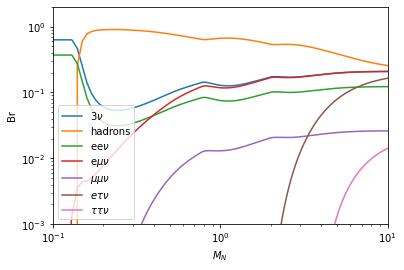

In [21]:
#reproduces the br plot with decay channels that felix has.
folder="br"
#3 nu curve
filename=f"model/{folder}/{folder}_3body_lep_sum_nua_bnub_nub.txt"
m3nu,br3nu=read_file(filename,name_col1="x",name_col2="y")

#hadron curve (done)
br_files=os.listdir(f"model/{folder}/")
had_file_char=f"{folder}_3body_inc"
had_file_char1=f"{folder}_2body_ex"
files_had=[f"{folder}_3body_inc",f"{folder}_2body_ex"]
mhad,brhad=add_br_files(files_had,folder)

#eev curve (done)
files_eev=[f"{folder}_3body_lep_lb_lb_nua_-11_11"]
meev,breev=add_br_files(files_eev,folder)

#emuv curve (not done)
files_emuv=[f"{folder}_3body_lep_la_lb_nub_11_-13_14"]
memuv,bremuv=add_br_files(files_emuv,folder)

#mumuv (done)
files_mumuv=[f"{folder}_3body_lep_lb_lb_nua_-13_13_12"]
mmumuv,brmumuv=add_br_files(files_mumuv,folder)

#etv (not done)
files_etv=[f"{folder}_3body_lep_la_lb_nub_11_-15_16"]
metv,bretv=add_br_files(files_etv,folder)

#ttv (done)
files_ttv=[f"{folder}_3body_lep_lb_lb_nua_-15_15_12"]
mttv,brttv=add_br_files(files_ttv,folder)

plt.plot(m3nu,br3nu,label=r"3$\nu$")
plt.plot(mhad,brhad,label=r"hadrons")
plt.plot(meev,breev,label=r"ee$\nu$")
plt.plot(memuv,bremuv,label=r"e$\mu \nu$")
plt.plot(mmumuv,brmumuv,label=r"$\mu \mu \nu$")
plt.plot(metv,bretv,label=r"$e \tau \nu$")
plt.plot(mttv,brttv, label=r"$\tau \tau \nu$")

plt.legend()

plt.xlabel(r"$M_N$")
plt.ylabel("Br")
plt.xlim(.1,10)
plt.ylim(10**-3,2)
plt.xscale("log")
plt.yscale("log")
plt.show()

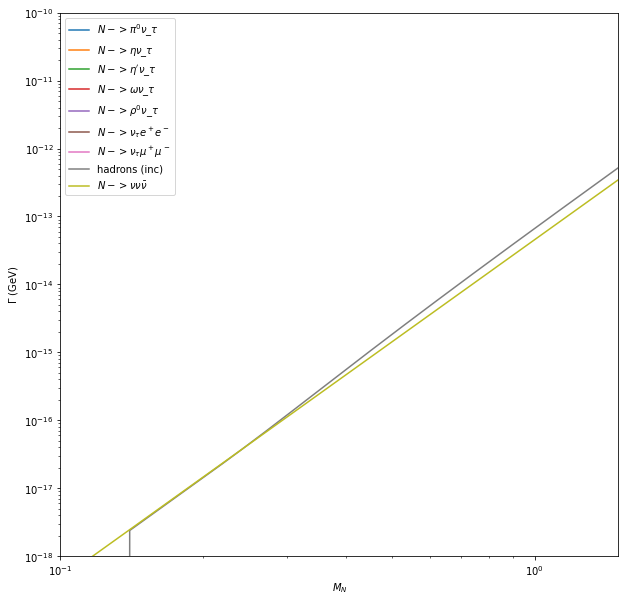

In [45]:
#adding all of the decay modes for decay into neutral mesons onto a single plot

#takes in a file and gives the x and y value of the file
def m_width(files,br_or_width):
    folder=f"{br_or_width}"
    m_width_df_temp = pd.read_csv(f"model/{folder}/{files}.txt",delimiter='       ',engine='python',names=['mass','width'],index_col=False,dtype='float64',skiprows=1)
    width=np.array(m_width_df_temp['width'].tolist())
    mass=np.array(m_width_df_temp['mass'].tolist())
    return(mass,width)


mbr_list=[]

br_or_width="width"
folder="width"
lep="15"
lep_nu="16"
orig_lep=r"$\tau$"
#K+
files=f"{br_or_width}_2body_ex_P_321_{lep}"
#brwidth is either the width or br
m,brwidth=m_width(files,br_or_width)
label=r"$N->K^+$"+ orig_lep+ r"$^-$"
#mbr_list.append([m,brwidth,label])

#pi+
files=f"{br_or_width}_2body_ex_P_211_{lep}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->\pi^+$"+ orig_lep+ r"$^-$"
#mbr_list.append([m,brwidth,label])

#pi0
files=f"{br_or_width}_2body_ex_P0_111_{lep_nu}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->\pi^0 \nu$" + "_" + orig_lep
mbr_list.append([m,brwidth,label])

#K0
files=f"{br_or_width}_2body_ex_P0_311_{lep_nu}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->K^0 \nu$" + "_" + orig_lep
#mbr_list.append([m,brwidth,label])

'''
#\bar{K0}
files=f"{br_or_width}_2body_ex_P0_-311_-{lep_nu}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->\bar{K}^0 \nu_e$"
mbr_list.append([m,brwidth,label])'''

#eta
files=f"{br_or_width}_2body_ex_P0_221_{lep_nu}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->\eta \nu$" + "_" + orig_lep
mbr_list.append([m,brwidth,label])

#eta'
files=f"{br_or_width}_2body_ex_P0_331_{lep_nu}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->\eta' \nu$" + "_" + orig_lep
mbr_list.append([m,brwidth,label])

#K*+
files=f"{br_or_width}_2body_ex_V_323_{lep}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->K^{*+}$"+ orig_lep+ r"$^-$"
#mbr_list.append([m,brwidth,label])

#rho+
files=f"{br_or_width}_2body_ex_V_213_{lep}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->\rho^+$"+ orig_lep+ r"$^-$"
#mbr_list.append([m,brwidth,label])

#K*0
files=f"{br_or_width}_2body_ex_V0_313_{lep_nu}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->K^{*0} \nu$" + "_" + orig_lep
#mbr_list.append([m,brwidth,label])

'''#\bar{K*0}
files=f"{br_or_width}_2body_ex_V0_-313_-12"
m,brwidth=m_width(files,br_or_width)
label=r"$N->\bar{K}^{*0} \nu_e$"
mbr_list.append([m,brwidth,label])'''

#omega
files=f"{br_or_width}_2body_ex_V0_223_{lep_nu}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->\omega \nu$" + "_" + orig_lep
mbr_list.append([m,brwidth,label])

#rho0
files=f"{br_or_width}_2body_ex_V0_113_{lep_nu}"
m,brwidth=m_width(files,br_or_width)
label=r"$N->\rho^0 \nu$" + "_" + orig_lep
mbr_list.append([m,brwidth,label])

#N->nu_tau e+ e-
files=["width_3body_lep_lb_lb_nua_-11_11_16"]
m,brwidth=add_br_files(files,br_or_width)
label=r"$N->\nu_{\tau} e^+ e^-$"
mbr_list.append([m,brwidth,label])

#N->nu_tau mu+ mu-
files=["width_3body_lep_lb_lb_nua_-13_13_16"]
m,brwidth=add_br_files(files,br_or_width)
label=r"$N->\nu_{\tau} \mu^+ \mu^-$"
mbr_list.append([m,brwidth,label])

#leptonic channels
br_or_width="width"
files_lep=[f"{br_or_width}_3body_lep"]
mlep,blep=add_br_files(files_lep,br_or_width)

#hadron curve inclusive
br_files=os.listdir(f"model/{folder}/")

had_file_char=f"{br_or_width}_3body_inc"
had_file_char1=f"{br_or_width}_2body_ex"
files_had=[f"{br_or_width}_3body_inc"]
#mhad_inc,brhad_inc=add_br_files(files_had,br_or_width)

#hadron curve exclusive
files_had=[f"{br_or_width}_2body_ex"]
#mhad_ex,brhad_ex=add_br_files(files_had,br_or_width)

#neutrino 3 body
files_nu=["width_3body_lep_sum_nua_bnub_nub"]
m_nu,br_nu=add_br_files(files_nu,br_or_width)




for n in range(len(mbr_list)):
    plt.plot(mbr_list[n][0],mbr_list[n][1],label=mbr_list[n][2])

plt.plot(mhad_inc,brhad_inc,label=r"hadrons (inc)")
#plt.plot(mhad_ex,brhad_ex,label=r"hadrons (ex)")
#plt.plot(mlep,blep,label="Leptonic Total")
plt.plot(m_nu,br_nu,label=r"$N->\nu \nu \bar{\nu}$")
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(prop={'size':10})
plt.xlabel(r"$M_N$")
plt.ylabel(r"$\Gamma$ (GeV)")
#plt.xlim(0,1.4)
#plt.ylim(10**-18,10**-10)
plt.xlim(.1,1.5)
plt.ylim(10**-18,10**-10)
plt.xscale("log")
plt.yscale("log")
plt.show()



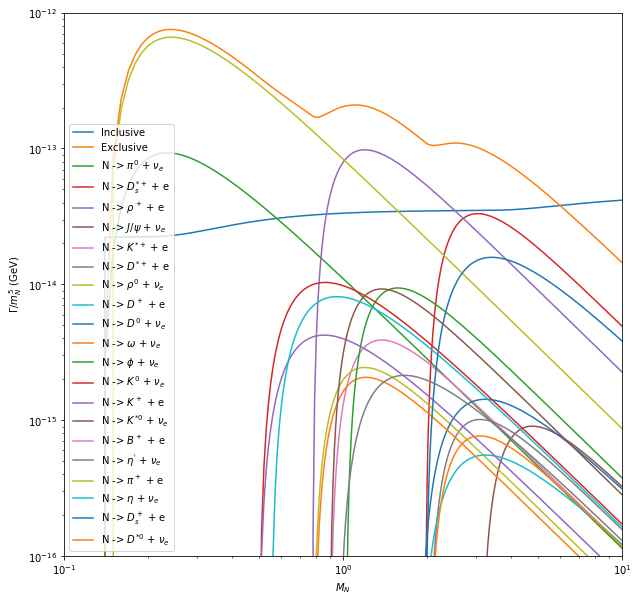

In [23]:
#plot total hadronic width (exclusive) and total hadronic width (inclusive) and all contributions to exclusive

#mbr_list is a list where each element has information to plot the decay channel
mbr_list=[]
br_or_width="width"
folder=f"{br_or_width}"
#pull all filenames in 'width' folder
br_files=os.listdir(f"model/{folder}/")
for n in range(0,len(br_files)):
    file_name=br_files[n]
    #print(file_name)
    if br_files[n][0:len("width_2body_ex")]=="width_2body_ex":
        m_width_df = pd.read_csv(f"model/width/{file_name}",delimiter='       ',engine='python',names=['mass','width'],index_col=False)
        #extract pids from file
        pids=m_width_df['mass'][0].split("\t")
        #remove pid row
        m_width_df=m_width_df.iloc[1: , :]
        #extract m and width
        m=m_width_df['mass'].tolist()
        #convert mass list to float
        m=np.array([float(m[x]) for x in range(len(m))])
        brwidth=np.array(m_width_df['width'].tolist())
        #create label
        if pids[2]=='none':
            particle1=hnl.symbols(pids[0])
            particle2=hnl.symbols(pids[1])
            label=f"N -> {particle1} + {particle2}"
        if pids[2]!='none':
            particle1=hnl.symbols(pids[0])
            particle2=hnl.symbols(pids[1])
            particle3=hnl.symbols(pids[2])
            label=f"N -> {particle1} + {particle2} + {particle3}"
        #only plot if the widths are nonzero
        if sum(brwidth)!=0:
            mbr_list.append([m,brwidth/m**5,label,file_name,pids[0]])


#total decay to hadrons (inclusive)
br_files=os.listdir(f"model/{folder}/")
files_had=[f"{br_or_width}_3body_inc"]
mhad_inc,brhad_inc=add_br_files(files_had,br_or_width)
plt.plot(mhad_inc,brhad_inc/mhad_inc**5,label="Inclusive")

#total decay to hadrons (exclusive)
files_had=[f"{br_or_width}_2body_ex"]
mhad_ex,brhad_ex=add_br_files(files_had,br_or_width)
plt.plot(mhad_ex,brhad_ex/((mhad_ex**5)),label="Exclusive")

for n in range(len(mbr_list)):
    plt.plot(mbr_list[n][0],mbr_list[n][1],label=mbr_list[n][2])

plt.rcParams["figure.figsize"] = (10,10)
plt.legend(prop={'size':10})
plt.xlabel(r"$M_N$")
plt.ylabel(r"$\Gamma/m_N^5$ (GeV)")
plt.xlim(.1,10)
plt.ylim(10**-16,10**-12)
plt.xscale("log")
plt.yscale("log")
plt.show()

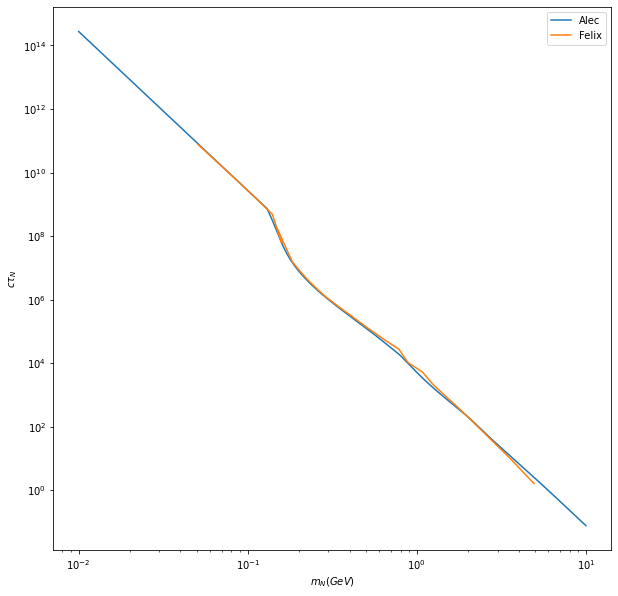

In [24]:
#comparing my ctau file with felix
from matplotlib import pyplot as plt

ctau_df = pd.read_csv(f"model/ctau.txt",delimiter='       ',engine='python',names=['mass','ctau'],index_col=False)
massf,ctauf=read_digitized_file(filename="/Users/alechewitt/Desktop/ctau_felix.csv",name_col1="x",name_col2="y")
mass=ctau_df['mass'].tolist()
ctau=ctau_df['ctau'].tolist()
plt.plot(mass,ctau,label="Alec")
plt.plot(massf,ctauf,label="Felix")
plt.legend()
plt.xlabel(r"$m_N (GeV)$")
plt.ylabel(r"$c \tau_N$")
plt.xscale("log")
plt.yscale("log")
plt.show()